<a href="https://colab.research.google.com/github/RK22000/SVIC/blob/main/SVC_Enhancement_to_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Outline
I want to verify if its possible to use an SVC to enhance a CNN



What kind of CNNs do I want to enhance?



In [55]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support




import numpy as np




## Fassion Mnist

### Loading Dataset and preparing dataloaders

In [2]:


full_training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
map = {i:0 for i in range(10)}
indexes = {i:[] for i in range(10)}
count, checked = 0, 0
for i in range(60000):
    if map[full_training_data[i][1]] < 1000:
        indexes[full_training_data[i][1]].append(i)
        map[full_training_data[i][1]] += 1
        count += 1
    checked += 1
    if count == 10000: break
map, count, checked, [len(i) for i in indexes.values()]

({0: 1000,
  1: 1000,
  2: 1000,
  3: 1000,
  4: 1000,
  5: 1000,
  6: 1000,
  7: 1000,
  8: 1000,
  9: 1000},
 10000,
 10648,
 [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

In [32]:
class ShrunkFashionMNIST(Dataset):
    def __init__(self, indexes):
        super().__init__()
        self.indicies = []
        for i in indexes.values():
            self.indicies.extend(i)
        #np.random.shuffle(self.indicies)
    
    def __len__(self):
        return len(self.indicies)
    
    def __getitem__(self, idx):
        return full_training_data[self.indicies[idx]]

training_data = ShrunkFashionMNIST(indexes)

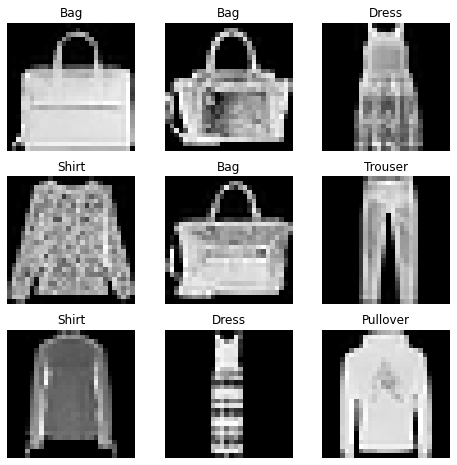

In [33]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
training_data[0][0].shape, training_data[0][1], len(training_data)

(torch.Size([1, 28, 28]), 5, 10000)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [35]:
training_dataloader = DataLoader(
    dataset=training_data,
    batch_size=100,
    shuffle=True,
    collate_fn=lambda x:tuple(x_.to(device) for x_ in default_collate(x))
)
testing_dataloader = DataLoader(
    dataset=test_data,
    batch_size=100,
    collate_fn=lambda x:tuple(x_.to(device) for x_ in default_collate(x))
)

### CNN

In [89]:
from torch.nn.modules.activation import Softmax
from torch import nn
class FASSION_Classifier(nn.Module):
    def __init__(self):
        super(FASSION_Classifier, self).__init__()
        self.cnn = nn.Sequential(
            # Convolution layer
            nn.Conv2d(
                in_channels=1, 
                out_channels=32,
                kernel_size=4,
                stride=2
                ),
            nn.ReLU(),
            nn.MaxPool2d(3, padding=1),

            nn.Flatten(),

            # Linear layer
            nn.Linear(32*5*5, 10),
            nn.ReLU()
        )
        self.terminal = nn.Sequential(
            # Terminal part
            nn.Linear(10, 10),
            nn.Softmax(dim=1)
        )
        nn.init.xavier_normal(self.cnn)
    
    def forward(self, x):
        return self.terminal(self.cnn(x))


In [27]:
model = FASSION_Classifier().to(device)
x = torch.rand(5, 1, 28, 28).to(device)
y = model(x)
y.shape, y, torch.sum(y, 1), y.argmax(1)

(torch.Size([5, 10]),
 tensor([[0.1013, 0.1305, 0.0685, 0.1177, 0.0812, 0.1194, 0.0721, 0.1161, 0.1189,
          0.0743],
         [0.1005, 0.1298, 0.0713, 0.1168, 0.0809, 0.1165, 0.0750, 0.1183, 0.1141,
          0.0770],
         [0.1010, 0.1289, 0.0684, 0.1172, 0.0812, 0.1196, 0.0720, 0.1187, 0.1169,
          0.0760],
         [0.1009, 0.1290, 0.0706, 0.1174, 0.0830, 0.1175, 0.0719, 0.1166, 0.1173,
          0.0760],
         [0.0990, 0.1310, 0.0722, 0.1171, 0.0802, 0.1190, 0.0781, 0.1129, 0.1137,
          0.0767]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
        grad_fn=<SumBackward1>),
 tensor([1, 1, 1, 1, 1], device='cuda:0'))

In [12]:
print(model)

FASSION_Classifier(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=800, out_features=10, bias=True)
    (5): ReLU()
  )
  (terminal): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)


### Training

In [50]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()
        losses.append(loss)

        if batch % 10 == 0:
            current = batch * len(X)
            accu = (pred.argmax(1)==y).type(torch.float).sum().item() / len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print(f"accu: {accu:>4f}")
    return losses

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in (dataloader):
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [28]:


def fit(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs=1):
    plt.figure()
    loss = []
    t_loss = []
    t_x = []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        t_loss.append(test_loop(test_dataloader, model, loss_fn)[0])
        t_x.append(len(loss))
        loss.extend( train_loop(train_dataloader, model, loss_fn, optimizer) )
    t_loss.append(test_loop(test_dataloader, model, loss_fn)[0])
    t_x.append(len(loss))    
    
    plt.plot([i+1 for i in range(len(loss))], loss, label='train loss')
    plt.plot(t_x, t_loss, 'o-', label='test loss')
    plt.legend()
    plt.show()
        
    print("Done!")


loss = []
t_loss = []
t_x = []
cnn_acu = []
svc_acu = []
all_tracks = [loss, t_loss, t_x, cnn_acu, svc_acu]
def test_track(model, test_dataloader, loss_fn):
    ls, ac = test_loop(test_dataloader, model, loss_fn)
    t_loss.append(ls)
    t_x.append(len(loss))
    cnn_acu.append(ac)
    
def fit_once(model, train_dataloader, loss_fn, optimizer):
    print(f"Fit Epoch {len(cnn_acu)}\n-------------------------------")
    loss.extend( train_loop(train_dataloader, model, loss_fn, optimizer) )

def plot_loss():
    plt.plot([i+1 for i in range(len(loss))], loss, label='train loss')
    plt.plot(t_x, t_loss, 'o-', label='test loss')
    plt.legend()
    plt.show()



In [12]:
model = FASSION_Classifier().to(device)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-8
optimizer = torch.optim.Adam(model.parameters()) #torch.optim.SGD(model.parameters(), lr=learning_rate)

#fit(model, training_dataloader, testing_dataloader, loss_fn, optimizer, 5)
# Got ~75% accuracy
# now lets see if the svc can do better than the terminal layers.


#### Fit once

In [139]:
fit_once(model, training_dataloader, loss_fn, optimizer)

Fit Epoch 12
-------------------------------
loss: 1.601668  [    0/60000]
accu: 0.860000
loss: 1.626079  [10000/60000]
accu: 0.830000
loss: 1.596286  [20000/60000]
accu: 0.870000
loss: 1.602503  [30000/60000]
accu: 0.860000
loss: 1.631583  [40000/60000]
accu: 0.830000
loss: 1.641482  [50000/60000]
accu: 0.830000


In [140]:
test_track(model, testing_dataloader, loss_fn)
len(all_tracks[0]), all_tracks[1:]

Test Error: 
 Accuracy: 82.2%, Avg loss: 1.640996 



(7200,
 [[2.3023557305335998,
   1.774617166519165,
   1.7554572379589082,
   1.7479732513427735,
   1.742242420911789,
   1.7383786976337432,
   1.7355019855499267,
   1.7330819976329803,
   1.7314404678344726,
   1.7177471172809602,
   1.644760671854019,
   1.6429707074165345,
   1.64099560379982],
  [0, 600, 1200, 1800, 2400, 3000, 3600, 4200, 4800, 5400, 6000, 6600, 7200],
  [0.0998,
   0.695,
   0.7088,
   0.7167,
   0.7214,
   0.7255,
   0.7277,
   0.7305,
   0.7308,
   0.745,
   0.8201,
   0.8203,
   0.8223],
  [0.5059,
   0.7632,
   0.7768,
   0.7828,
   0.7881,
   0.7922,
   0.7944,
   0.7962,
   0.7972,
   0.7994,
   0.8178,
   0.8183]])

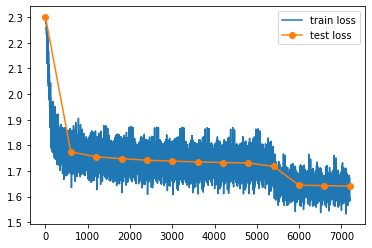

In [141]:
plot_loss()

In [15]:
model_file = '/content/drive/MyDrive/ML Experiments/FashionMNIST_cnn_to_svc.pth'
torch.save(model, model_file)

In [16]:
model_loaded = torch.load(model_file)

In [17]:
test_loop(testing_dataloader, model_loaded, nn.CrossEntropyLoss())

Test Error: 
 Accuracy: 75.3%, Avg loss: 1.711543 



1.711542739868164

In [18]:
for param in model.parameters(True):
    param.requires_grad=False

### SVC

In [14]:
import numpy as np
class Dset:
    def __init__(self, x=[], y=[]):
        self.x = x
        self.y = y

In [142]:
with torch.no_grad():
    X, y = [], []
    for _x, _y in tqdm(testing_dataloader):
        X.extend(model.cnn(_x).to('cpu').numpy())
        y.extend(_y.to('cpu'))
        #print(len(X))
    test = Dset(np.array(X), np.array(y))
    print("Test dset")
    print(test.x.shape, test.y.shape)

    X, y = [], []
    for _x, _y in tqdm(training_dataloader):
        X.extend(model.cnn(_x).to('cpu').numpy())
        y.extend(_y.to('cpu'))
    train = Dset(np.array(X), np.array(y))
    print("Train dset")
    print(train.x.shape, train.y.shape)



100%|██████████| 100/100 [00:00<00:00, 101.82it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 600/600 [00:05<00:00, 103.37it/s]


Train dset
(60000, 10) (60000,)


In [21]:
test.x.shape, test.y.shape

((10000, 10), (10000,))

In [143]:
# Linear kernel
from sklearn.svm import LinearSVC
linear_clf = make_pipeline(StandardScaler(), LinearSVC())
linear_clf.fit(train.x, train.y)
svc_acu.append(linear_clf.score(test.x, test.y))
svc_acu[-1]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8206

In [116]:
len(all_tracks[0]), all_tracks[1:]

(5400,
 [[2.3023557305335998,
   1.774617166519165,
   1.7554572379589082,
   1.7479732513427735,
   1.742242420911789,
   1.7383786976337432,
   1.7355019855499267,
   1.7330819976329803,
   1.7314404678344726,
   1.7177471172809602],
  [0, 600, 1200, 1800, 2400, 3000, 3600, 4200, 4800, 5400],
  [0.0998,
   0.695,
   0.7088,
   0.7167,
   0.7214,
   0.7255,
   0.7277,
   0.7305,
   0.7308,
   0.745],
  [0.5059,
   0.7632,
   0.7768,
   0.7828,
   0.7881,
   0.7922,
   0.7944,
   0.7962,
   0.7972,
   0.7994]])

In [150]:
clf = make_pipeline(StandardScaler(), SVC())
clf.fit(train.x, train.y)
clf.score(test.x, test.y)

0.8497

### Composite model

In [17]:
class Enhanced_Model(nn.Module) :
    def __init__(self, cnn_model, svc_model):
        super(Enhanced_Model, self).__init__()
        self.cnn = cnn_model
        self.svc = svc_model
    def forward(self, x):
        return self.svc.predict(self.cnn.cnn(x).detach().to('cpu'))

In [144]:
emodel = Enhanced_Model(model, linear_clf)

In [26]:
X = torch.rand(5, 1, 28, 28).to(device)
emodel(X), emodel.cnn(X).argmax(1)

(array([8, 8, 8, 8, 6]), tensor([6, 6, 6, 6, 6], device='cuda:0'))

### Model performance comparison

In [145]:
y_true = []
y_cnn = []
y_svc = []

with torch.no_grad():
    for X, y in tqdm(testing_dataloader):
        y_true.extend(y.to('cpu'))
        y_cnn.extend(emodel.cnn(X).argmax(1).to('cpu').numpy())
        y_svc.extend(emodel(X))
len(y_true), len(y_cnn), len(y_svc)

100%|██████████| 100/100 [00:01<00:00, 84.80it/s]


(10000, 10000, 10000)

(0.0, 1.0, 0.0, 1.0)

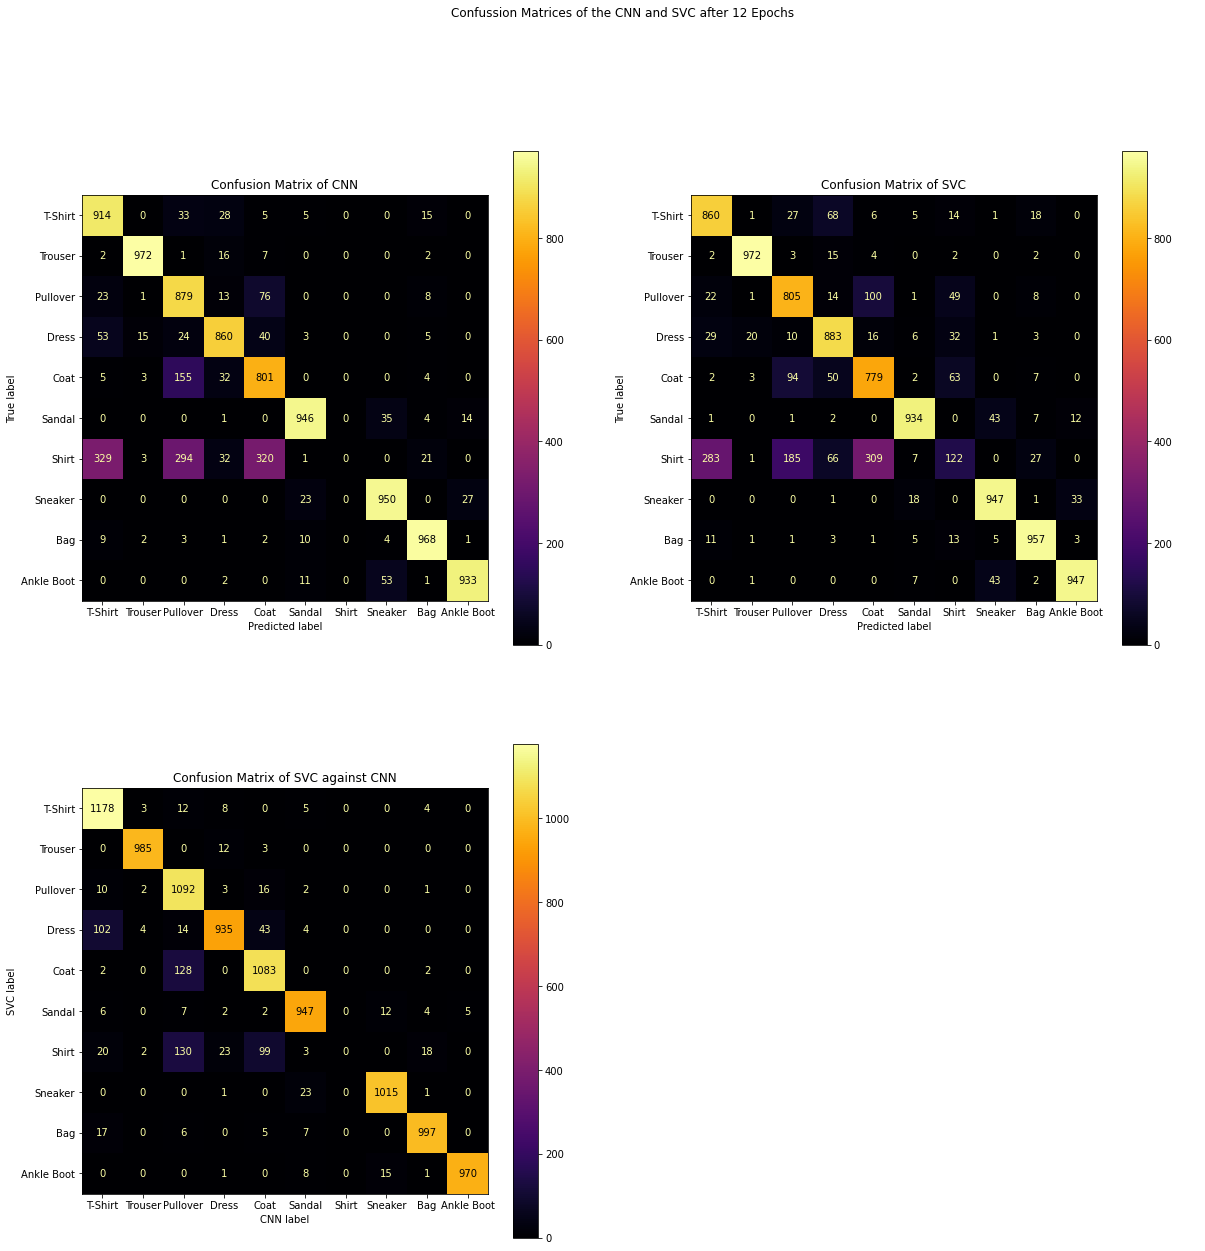

In [148]:
epk = len(svc_acu)-1
fig, ((axCNN, axSVC), (ax, _)) = plt.subplots(2, 2, figsize=(20,20))
cmap='inferno'
plt.suptitle(f"Confussion Matrices of the CNN and SVC after {epk} Epochs")

axCNN.set_title("Confusion Matrix of CNN")
conf_cnn = ConfusionMatrixDisplay.from_predictions(
    y_true, 
    y_cnn, 
    display_labels=labels_map.values(),
    ax = axCNN,
    cmap=cmap
    )

axSVC.set_title("Confusion Matrix of SVC")
conf_svc = ConfusionMatrixDisplay.from_predictions(
    y_true, 
    y_svc, 
    display_labels=labels_map.values(),
    ax=axSVC,
    cmap=cmap
    )

ax.set_title("Confusion Matrix of SVC against CNN")
ConfusionMatrixDisplay.from_predictions(
    y_svc, 
    y_cnn, 
    display_labels=labels_map.values(),
    ax=ax,
    cmap=cmap
    )
ax.set_xlabel("CNN label")
ax.set_ylabel("SVC label")

_.axis('off')

#fig.savefig(f"/content/drive/MyDrive/ML Experiments/FashionMNIST_cnn_svc_figs/conf_epoch_{epk}")

In [39]:
def plot_acu():
    plt.plot(cnn_acu, 'o-', label='CNN Accuracies')
    plt.plot(svc_acu, 'o-', label='SVC Accuracies')
    plt.legend()
    plt.show()

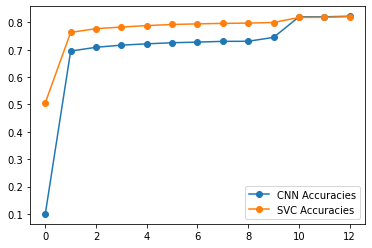

In [147]:
plot_acu()

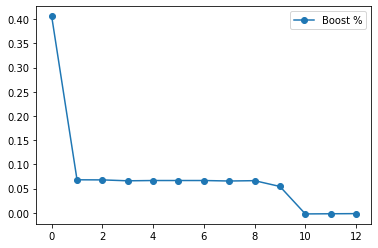

In [152]:
plt.plot([i-j for i, j in zip(svc_acu, cnn_acu)], 'o-', label='Boost %')
plt.legend()

In [149]:
conf_cnn.confusion_matrix

array([[914,   0,  33,  28,   5,   5,   0,   0,  15,   0],
       [  2, 972,   1,  16,   7,   0,   0,   0,   2,   0],
       [ 23,   1, 879,  13,  76,   0,   0,   0,   8,   0],
       [ 53,  15,  24, 860,  40,   3,   0,   0,   5,   0],
       [  5,   3, 155,  32, 801,   0,   0,   0,   4,   0],
       [  0,   0,   0,   1,   0, 946,   0,  35,   4,  14],
       [329,   3, 294,  32, 320,   1,   0,   0,  21,   0],
       [  0,   0,   0,   0,   0,  23,   0, 950,   0,  27],
       [  9,   2,   3,   1,   2,  10,   0,   4, 968,   1],
       [  0,   0,   0,   2,   0,  11,   0,  53,   1, 933]])

## Define Experiment
Lets try to compile everything down in fashion Mnist into a single experiemnt function so all of that can be automated

# Experiment

## Definitions

In [46]:
loss = []
t_loss = []
t_x = []
cnn_acu = []
lin_svc_acu = []
pol_svc_acu = []
rbf_svc_acu = []
all_tracks = [loss, t_loss, t_x, cnn_acu, lin_svc_acu]
def test_track(model, test_dataloader, loss_fn):
    ls, ac = test_loop(test_dataloader, model, loss_fn)
    t_loss.append(ls)
    t_x.append(len(loss))
    cnn_acu.append(ac)
    
def fit_once(model, train_dataloader, loss_fn, optimizer):
    print(f"Fit Epoch {len(cnn_acu)}\n-------------------------------")
    loss.extend( train_loop(train_dataloader, model, loss_fn, optimizer) )

def plot_loss():
    plt.figure()
    plt.title("CNN Loss")
    plt.plot([i+1 for i in range(len(loss))], loss, label='train loss')
    plt.plot(t_x, t_loss, 'o-', label='test loss')
    plt.legend()
    plt.show()

In [13]:
import numpy as np
class Dset:
    def __init__(self, x=[], y=[]):
        self.x = x
        self.y = y

In [14]:
def prep_svc_data():
    print("Preparing SVC data")
    with torch.no_grad():
        X, y = [], []
        for _x, _y in tqdm(testing_dataloader):
            X.extend(model.cnn(_x).to('cpu').numpy())
            y.extend(_y.to('cpu'))
            #print(len(X))
        test = Dset(np.array(X), np.array(y))
        print("Test dset")
        print(test.x.shape, test.y.shape)

        X, y = [], []
        for _x, _y in tqdm(training_dataloader):
            X.extend(model.cnn(_x).to('cpu').numpy())
            y.extend(_y.to('cpu'))
        train = Dset(np.array(X), np.array(y))
        print("Train dset")
        print(train.x.shape, train.y.shape)
        return test, train



In [15]:
class Enhanced_Model(nn.Module) :
    def __init__(self, cnn_model, lin_svc_model, pol_svc_model, rbf_svc_model):
        super(Enhanced_Model, self).__init__()
        self.cnn = cnn_model
        self.svc_lin = lin_svc_model
        self.svc_pol = pol_svc_model
        self.svc_rbf = rbf_svc_model
    def forward(self, x):
        with torch.no_grad():
            cnn_pass = self.cnn.cnn(x).detach().to('cpu')
        return self.svc_lin.predict(cnn_pass), self.svc_pol.predict(cnn_pass), self.svc_rbf.predict(cnn_pass)

In [85]:
def conf_an_stuff(emodel):
    y_true = []
    y_cnn = []
    y_svc_lin = []
    y_svc_pol = []
    y_svc_rbf = []
    

    with torch.no_grad():
        print("loading data for conf and stuff")
        for X, y in tqdm(testing_dataloader):
            y_true.extend(y.to('cpu'))
            y_cnn.extend(emodel.cnn(X).argmax(1).to('cpu').numpy())
            i, j, k = emodel(X)
            y_svc_lin.extend(i)
            y_svc_pol.extend(j)
            y_svc_rbf.extend(k)

    epk = len(cnn_acu)-1
    fig, ((axCNN, axSVClin), (axSVCpol, axSVCrbf)) = plt.subplots(2, 2, figsize=(20,20))
    cmap='inferno'
    plt.suptitle(f"Confussion Matrices of the CNN and SVC after {epk} Epochs")

    axCNN.set_title("Confusion Matrix of CNN")
    conf_cnn = ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_cnn, 
        display_labels=labels_map.values(),
        ax = axCNN,
        cmap=cmap
        )

    axSVClin.set_title("Confusion Matrix of Linear SVC")
    conf_svc = ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_svc_lin, 
        display_labels=labels_map.values(),
        ax=axSVClin,
        cmap=cmap
        )

    axSVCpol.set_title("Confusion Matrix of Polynomial SVC")
    conf_svc = ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_svc_pol, 
        display_labels=labels_map.values(),
        ax=axSVCpol,
        cmap=cmap
        )
    
    axSVCrbf.set_title("Confusion Matrix of RBF SVC")
    conf_svc = ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_svc_rbf, 
        display_labels=labels_map.values(),
        ax=axSVCrbf,
        cmap=cmap
        )

    fig.savefig(f"/content/drive/MyDrive/ML Experiments/round2_conf/conf_epoch_{epk}")

    cnnF = precision_recall_fscore_support(y_true, y_cnn, average='micro')[:-1]
    linF = precision_recall_fscore_support(y_true, y_svc_lin, average='micro')[:-1]
    polF = precision_recall_fscore_support(y_true, y_svc_pol, average='micro')[:-1]
    rbfF = precision_recall_fscore_support(y_true, y_svc_rbf, average='micro')[:-1]
    plt.figure()
    plt.title(f"Precission, Recall, Fscore after {epk} Epochs")
    x=[i*0.8*6 for i in range(3)]
    plt.xticks([1.2+i for i in x], ['Precission', 'Recall', 'Fscore'])
    print(len(x), len(cnnF))
    print(cnnF)
    plt.bar(x, cnnF, label="CNN")
    plt.bar([0.8+i for i in x], linF, label="Linear SVC")
    plt.bar([1.6+i for i in x], linF, label="Polynomial SVC")
    plt.bar([2.4+i for i in x], linF, label="RBF SVC")
    plt.xlim(right=25)
    plt.axhline(y=1, ls=':')
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/ML Experiments/round2_prc/prc_epoch_{epk}")

In [45]:
def plot_acu():
    plt.figure()
    plt.title("Model accuracies against epochs")
    plt.plot(cnn_acu, 'o-', label='CNN Accuracies')
    plt.plot(lin_svc_acu, 'o-', label='Linear SVC Accuracies')
    plt.plot(pol_svc_acu, 'o-', label='Polynomial SVC Accuracies')
    plt.plot(rbf_svc_acu, 'o-', label='RBF SVC Accuracies')
    plt.legend()
    plt.show()

## Experiment func

In [51]:
def exp(model, epochs):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    test_track(model, testing_dataloader, loss_fn)
    test, train = prep_svc_data()
    # Linear SVC
    linear_clf = make_pipeline(StandardScaler(), LinearSVC())
    linear_clf.fit(train.x, train.y)
    lin_svc_acu.append(linear_clf.score(test.x, test.y))
    print(f"Linear SVC accuracy: {lin_svc_acu[-1]}")

    # Polynomial SVC
    poly_clf = make_pipeline(StandardScaler(), SVC(kernel='poly'))
    poly_clf.fit(train.x, train.y)
    pol_svc_acu.append(poly_clf.score(test.x, test.y))
    print(f"Polynomial SVC accuracy: {pol_svc_acu[-1]}")

    # RBF SVC
    rbf_clf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
    rbf_clf.fit(train.x, train.y)
    rbf_svc_acu.append(rbf_clf.score(test.x, test.y))
    print(f"RBF SVC accuracy: {rbf_svc_acu[-1]}")

    
    print(cnn_acu, lin_svc_acu)
    emodel = Enhanced_Model(model, linear_clf, poly_clf, rbf_clf)
    conf_an_stuff(emodel)
    
    for t in range(epochs):
        print('\n')
        fit_once(model, training_dataloader, loss_fn, optimizer)
        test_track(model, testing_dataloader, loss_fn)
        test, train = prep_svc_data()
        # Linear SVC
        linear_clf = make_pipeline(StandardScaler(), LinearSVC())
        linear_clf.fit(train.x, train.y)
        lin_svc_acu.append(linear_clf.score(test.x, test.y))
        print(f"Linear SVC accuracy: {lin_svc_acu[-1]}")

        # Polynomial SVC
        poly_clf = make_pipeline(StandardScaler(), SVC(kernel='poly'))
        poly_clf.fit(train.x, train.y)
        pol_svc_acu.append(poly_clf.score(test.x, test.y))
        print(f"Polynomial SVC accuracy: {pol_svc_acu[-1]}")

        # RBF SVC
        rbf_clf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
        rbf_clf.fit(train.x, train.y)
        rbf_svc_acu.append(rbf_clf.score(test.x, test.y))
        print(f"RBF SVC accuracy: {rbf_svc_acu[-1]}")

        
        print(cnn_acu, lin_svc_acu)
        emodel = Enhanced_Model(model, linear_clf, poly_clf, rbf_clf)
        conf_an_stuff(emodel)
        
    plot_loss()
    plot_acu()

    return emodel

In [78]:
model = FASSION_Classifier().to(device)

Test Error: 
 Accuracy: 11.8%, Avg loss: 2.302111 

Preparing SVC data


100%|██████████| 100/100 [00:00<00:00, 103.79it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:00<00:00, 104.29it/s]


Train dset
(10000, 10) (10000,)


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVC accuracy: 0.5466
Polynomial SVC accuracy: 0.5978
RBF SVC accuracy: 0.625
[0.1175] [0.5466]
loading data for conf and stuff


100%|██████████| 100/100 [00:09<00:00, 10.75it/s]


3 3
(0.1175, 0.1175, 0.1175)
Fit Epoch 1
-------------------------------
loss: 2.304557  [    0/10000]
accu: 0.070000
loss: 2.288093  [ 1000/10000]
accu: 0.130000
loss: 2.266881  [ 2000/10000]
accu: 0.130000
loss: 2.259890  [ 3000/10000]
accu: 0.170000
loss: 2.237240  [ 4000/10000]
accu: 0.230000
loss: 2.198585  [ 5000/10000]
accu: 0.250000
loss: 2.153030  [ 6000/10000]
accu: 0.320000
loss: 2.193706  [ 7000/10000]
accu: 0.230000
loss: 2.137890  [ 8000/10000]
accu: 0.350000
loss: 2.155894  [ 9000/10000]
accu: 0.300000
Test Error: 
 Accuracy: 36.4%, Avg loss: 2.099972 

Preparing SVC data


100%|██████████| 100/100 [00:00<00:00, 104.95it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:00<00:00, 102.04it/s]


Train dset
(10000, 10) (10000,)


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVC accuracy: 0.6037
Polynomial SVC accuracy: 0.6262
RBF SVC accuracy: 0.6323
[0.1175, 0.3635] [0.5466, 0.6037]
loading data for conf and stuff


100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


3 3
(0.3635, 0.3635, 0.36349999999999993)
Fit Epoch 2
-------------------------------
loss: 2.142756  [    0/10000]
accu: 0.300000
loss: 2.056896  [ 1000/10000]
accu: 0.420000
loss: 2.081270  [ 2000/10000]
accu: 0.330000
loss: 1.998348  [ 3000/10000]
accu: 0.420000
loss: 2.040757  [ 4000/10000]
accu: 0.380000
loss: 2.034302  [ 5000/10000]
accu: 0.430000
loss: 1.963801  [ 6000/10000]
accu: 0.570000
loss: 2.024432  [ 7000/10000]
accu: 0.520000
loss: 2.030742  [ 8000/10000]
accu: 0.420000
loss: 2.008685  [ 9000/10000]
accu: 0.470000
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.953298 

Preparing SVC data


100%|██████████| 100/100 [00:01<00:00, 92.45it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:01<00:00, 98.78it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.6597
Polynomial SVC accuracy: 0.6789
RBF SVC accuracy: 0.6869
[0.1175, 0.3635, 0.5371] [0.5466, 0.6037, 0.6597]
loading data for conf and stuff


100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


3 3
(0.5371, 0.5371, 0.5371)
Fit Epoch 3
-------------------------------
loss: 1.947275  [    0/10000]
accu: 0.540000
loss: 1.913871  [ 1000/10000]
accu: 0.580000
loss: 1.873339  [ 2000/10000]
accu: 0.600000
loss: 1.913243  [ 3000/10000]
accu: 0.570000
loss: 1.878164  [ 4000/10000]
accu: 0.610000
loss: 1.861881  [ 5000/10000]
accu: 0.630000
loss: 1.951586  [ 6000/10000]
accu: 0.520000
loss: 1.922776  [ 7000/10000]
accu: 0.560000
loss: 1.932731  [ 8000/10000]
accu: 0.560000
loss: 1.809662  [ 9000/10000]
accu: 0.700000
Test Error: 
 Accuracy: 64.7%, Avg loss: 1.859651 

Preparing SVC data


100%|██████████| 100/100 [00:00<00:00, 107.23it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:00<00:00, 106.16it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.6986
Polynomial SVC accuracy: 0.7107
RBF SVC accuracy: 0.718
[0.1175, 0.3635, 0.5371, 0.6474] [0.5466, 0.6037, 0.6597, 0.6986]
loading data for conf and stuff


100%|██████████| 100/100 [00:07<00:00, 14.04it/s]


3 3
(0.6474, 0.6474, 0.6474)
Fit Epoch 4
-------------------------------
loss: 1.868273  [    0/10000]
accu: 0.620000
loss: 1.797586  [ 1000/10000]
accu: 0.750000
loss: 1.791733  [ 2000/10000]
accu: 0.730000
loss: 1.814558  [ 3000/10000]
accu: 0.730000
loss: 1.788781  [ 4000/10000]
accu: 0.760000
loss: 1.876076  [ 5000/10000]
accu: 0.620000
loss: 1.808588  [ 6000/10000]
accu: 0.710000
loss: 1.804107  [ 7000/10000]
accu: 0.680000
loss: 1.793016  [ 8000/10000]
accu: 0.680000
loss: 1.828300  [ 9000/10000]
accu: 0.660000
Test Error: 
 Accuracy: 69.3%, Avg loss: 1.792026 

Preparing SVC data


100%|██████████| 100/100 [00:00<00:00, 105.30it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:00<00:00, 107.05it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.7085
Polynomial SVC accuracy: 0.7271
RBF SVC accuracy: 0.7349
[0.1175, 0.3635, 0.5371, 0.6474, 0.6934] [0.5466, 0.6037, 0.6597, 0.6986, 0.7085]
loading data for conf and stuff


100%|██████████| 100/100 [00:06<00:00, 14.90it/s]


3 3
(0.6934, 0.6934, 0.6934)
Fit Epoch 5
-------------------------------
loss: 1.742274  [    0/10000]
accu: 0.750000
loss: 1.832942  [ 1000/10000]
accu: 0.620000
loss: 1.817063  [ 2000/10000]
accu: 0.690000
loss: 1.786556  [ 3000/10000]
accu: 0.690000
loss: 1.796429  [ 4000/10000]
accu: 0.690000
loss: 1.830755  [ 5000/10000]
accu: 0.650000
loss: 1.749915  [ 6000/10000]
accu: 0.720000
loss: 1.811869  [ 7000/10000]
accu: 0.670000
loss: 1.827835  [ 8000/10000]
accu: 0.650000
loss: 1.771141  [ 9000/10000]
accu: 0.700000
Test Error: 
 Accuracy: 70.9%, Avg loss: 1.768709 

Preparing SVC data


100%|██████████| 100/100 [00:00<00:00, 105.50it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:00<00:00, 100.41it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.7098
Polynomial SVC accuracy: 0.7359
RBF SVC accuracy: 0.7412
[0.1175, 0.3635, 0.5371, 0.6474, 0.6934, 0.7086] [0.5466, 0.6037, 0.6597, 0.6986, 0.7085, 0.7098]
loading data for conf and stuff


100%|██████████| 100/100 [00:06<00:00, 15.47it/s]


3 3
(0.7086, 0.7086, 0.7085999999999999)
Fit Epoch 6
-------------------------------
loss: 1.741263  [    0/10000]
accu: 0.750000
loss: 1.764935  [ 1000/10000]
accu: 0.720000
loss: 1.750698  [ 2000/10000]
accu: 0.720000
loss: 1.762996  [ 3000/10000]
accu: 0.730000
loss: 1.747899  [ 4000/10000]
accu: 0.730000
loss: 1.804719  [ 5000/10000]
accu: 0.670000
loss: 1.771950  [ 6000/10000]
accu: 0.690000
loss: 1.808643  [ 7000/10000]
accu: 0.670000
loss: 1.776934  [ 8000/10000]
accu: 0.680000
loss: 1.783264  [ 9000/10000]
accu: 0.680000
Test Error: 
 Accuracy: 71.2%, Avg loss: 1.760764 

Preparing SVC data


100%|██████████| 100/100 [00:00<00:00, 107.46it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:00<00:00, 106.13it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.7138
Polynomial SVC accuracy: 0.7404
RBF SVC accuracy: 0.7465
[0.1175, 0.3635, 0.5371, 0.6474, 0.6934, 0.7086, 0.7121] [0.5466, 0.6037, 0.6597, 0.6986, 0.7085, 0.7098, 0.7138]
loading data for conf and stuff


100%|██████████| 100/100 [00:06<00:00, 15.58it/s]


3 3
(0.7121, 0.7121, 0.7121000000000001)
Fit Epoch 7
-------------------------------
loss: 1.781465  [    0/10000]
accu: 0.690000
loss: 1.707677  [ 1000/10000]
accu: 0.780000
loss: 1.711521  [ 2000/10000]
accu: 0.760000
loss: 1.774927  [ 3000/10000]
accu: 0.680000
loss: 1.798524  [ 4000/10000]
accu: 0.660000
loss: 1.755757  [ 5000/10000]
accu: 0.720000
loss: 1.727519  [ 6000/10000]
accu: 0.760000
loss: 1.736363  [ 7000/10000]
accu: 0.760000
loss: 1.768523  [ 8000/10000]
accu: 0.710000
loss: 1.826203  [ 9000/10000]
accu: 0.640000
Test Error: 
 Accuracy: 71.7%, Avg loss: 1.753557 

Preparing SVC data


100%|██████████| 100/100 [00:01<00:00, 85.65it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:01<00:00, 97.24it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.7207
Polynomial SVC accuracy: 0.7474
RBF SVC accuracy: 0.7517
[0.1175, 0.3635, 0.5371, 0.6474, 0.6934, 0.7086, 0.7121, 0.7166] [0.5466, 0.6037, 0.6597, 0.6986, 0.7085, 0.7098, 0.7138, 0.7207]
loading data for conf and stuff


100%|██████████| 100/100 [00:06<00:00, 15.52it/s]


3 3
(0.7166, 0.7166, 0.7166)
Fit Epoch 8
-------------------------------
loss: 1.757570  [    0/10000]
accu: 0.700000
loss: 1.739564  [ 1000/10000]
accu: 0.740000
loss: 1.772853  [ 2000/10000]
accu: 0.700000
loss: 1.719178  [ 3000/10000]
accu: 0.760000
loss: 1.775948  [ 4000/10000]
accu: 0.700000
loss: 1.754228  [ 5000/10000]
accu: 0.720000
loss: 1.730110  [ 6000/10000]
accu: 0.740000
loss: 1.767851  [ 7000/10000]
accu: 0.700000
loss: 1.732215  [ 8000/10000]
accu: 0.740000
loss: 1.691769  [ 9000/10000]
accu: 0.800000
Test Error: 
 Accuracy: 71.7%, Avg loss: 1.753570 

Preparing SVC data


100%|██████████| 100/100 [00:00<00:00, 107.79it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:00<00:00, 103.54it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.7255
Polynomial SVC accuracy: 0.7509
RBF SVC accuracy: 0.7537
[0.1175, 0.3635, 0.5371, 0.6474, 0.6934, 0.7086, 0.7121, 0.7166, 0.7171] [0.5466, 0.6037, 0.6597, 0.6986, 0.7085, 0.7098, 0.7138, 0.7207, 0.7255]
loading data for conf and stuff


100%|██████████| 100/100 [00:06<00:00, 14.78it/s]


3 3
(0.7171, 0.7171, 0.7171)
Fit Epoch 9
-------------------------------
loss: 1.728978  [    0/10000]
accu: 0.750000
loss: 1.707535  [ 1000/10000]
accu: 0.760000
loss: 1.758254  [ 2000/10000]
accu: 0.730000
loss: 1.679408  [ 3000/10000]
accu: 0.800000
loss: 1.664068  [ 4000/10000]
accu: 0.810000
loss: 1.738366  [ 5000/10000]
accu: 0.740000
loss: 1.727122  [ 6000/10000]
accu: 0.720000
loss: 1.760587  [ 7000/10000]
accu: 0.710000
loss: 1.718406  [ 8000/10000]
accu: 0.740000
loss: 1.786576  [ 9000/10000]
accu: 0.700000
Test Error: 
 Accuracy: 72.0%, Avg loss: 1.749055 

Preparing SVC data


100%|██████████| 100/100 [00:01<00:00, 81.00it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:01<00:00, 99.38it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.7272
Polynomial SVC accuracy: 0.7523
RBF SVC accuracy: 0.7549
[0.1175, 0.3635, 0.5371, 0.6474, 0.6934, 0.7086, 0.7121, 0.7166, 0.7171, 0.7204] [0.5466, 0.6037, 0.6597, 0.6986, 0.7085, 0.7098, 0.7138, 0.7207, 0.7255, 0.7272]
loading data for conf and stuff


100%|██████████| 100/100 [00:06<00:00, 16.19it/s]


3 3
(0.7204, 0.7204, 0.7204)
Fit Epoch 10
-------------------------------
loss: 1.737082  [    0/10000]
accu: 0.740000
loss: 1.739199  [ 1000/10000]
accu: 0.720000
loss: 1.768754  [ 2000/10000]
accu: 0.710000
loss: 1.723998  [ 3000/10000]
accu: 0.750000
loss: 1.733391  [ 4000/10000]
accu: 0.740000
loss: 1.655984  [ 5000/10000]
accu: 0.810000
loss: 1.740153  [ 6000/10000]
accu: 0.720000
loss: 1.709612  [ 7000/10000]
accu: 0.760000
loss: 1.721283  [ 8000/10000]
accu: 0.750000
loss: 1.725236  [ 9000/10000]
accu: 0.740000
Test Error: 
 Accuracy: 72.3%, Avg loss: 1.744681 

Preparing SVC data


100%|██████████| 100/100 [00:01<00:00, 80.98it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:00<00:00, 103.82it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.7278
Polynomial SVC accuracy: 0.7534
RBF SVC accuracy: 0.7549
[0.1175, 0.3635, 0.5371, 0.6474, 0.6934, 0.7086, 0.7121, 0.7166, 0.7171, 0.7204, 0.7233] [0.5466, 0.6037, 0.6597, 0.6986, 0.7085, 0.7098, 0.7138, 0.7207, 0.7255, 0.7272, 0.7278]
loading data for conf and stuff


100%|██████████| 100/100 [00:06<00:00, 15.87it/s]
<ipython-input-80-d26fc2b1fb8d>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ((axCNN, axSVClin), (axSVCpol, axSVCrbf)) = plt.subplots(2, 2, figsize=(20,20))
<ipython-input-80-d26fc2b1fb8d>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


3 3
(0.7233, 0.7233, 0.7233)
Fit Epoch 11
-------------------------------
loss: 1.790944  [    0/10000]
accu: 0.680000
loss: 1.719253  [ 1000/10000]
accu: 0.760000
loss: 1.788037  [ 2000/10000]
accu: 0.680000
loss: 1.777647  [ 3000/10000]
accu: 0.690000
loss: 1.679524  [ 4000/10000]
accu: 0.800000
loss: 1.674144  [ 5000/10000]
accu: 0.800000
loss: 1.726585  [ 6000/10000]
accu: 0.740000
loss: 1.751277  [ 7000/10000]
accu: 0.720000
loss: 1.726551  [ 8000/10000]
accu: 0.740000
loss: 1.734935  [ 9000/10000]
accu: 0.750000
Test Error: 
 Accuracy: 72.2%, Avg loss: 1.744552 

Preparing SVC data


100%|██████████| 100/100 [00:00<00:00, 105.21it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:00<00:00, 103.20it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.7275
Polynomial SVC accuracy: 0.752
RBF SVC accuracy: 0.7553
[0.1175, 0.3635, 0.5371, 0.6474, 0.6934, 0.7086, 0.7121, 0.7166, 0.7171, 0.7204, 0.7233, 0.7219] [0.5466, 0.6037, 0.6597, 0.6986, 0.7085, 0.7098, 0.7138, 0.7207, 0.7255, 0.7272, 0.7278, 0.7275]
loading data for conf and stuff


100%|██████████| 100/100 [00:06<00:00, 16.17it/s]
<ipython-input-80-d26fc2b1fb8d>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ((axCNN, axSVClin), (axSVCpol, axSVCrbf)) = plt.subplots(2, 2, figsize=(20,20))
<ipython-input-80-d26fc2b1fb8d>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


3 3
(0.7219, 0.7219, 0.7219)
Fit Epoch 12
-------------------------------
loss: 1.706860  [    0/10000]
accu: 0.770000
loss: 1.762311  [ 1000/10000]
accu: 0.700000
loss: 1.797176  [ 2000/10000]
accu: 0.670000
loss: 1.807676  [ 3000/10000]
accu: 0.640000
loss: 1.681493  [ 4000/10000]
accu: 0.790000
loss: 1.645007  [ 5000/10000]
accu: 0.830000
loss: 1.716895  [ 6000/10000]
accu: 0.750000
loss: 1.786043  [ 7000/10000]
accu: 0.680000
loss: 1.651828  [ 8000/10000]
accu: 0.810000
loss: 1.679250  [ 9000/10000]
accu: 0.780000
Test Error: 
 Accuracy: 72.6%, Avg loss: 1.740367 

Preparing SVC data


100%|██████████| 100/100 [00:00<00:00, 104.79it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:01<00:00, 99.51it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.7306
Polynomial SVC accuracy: 0.7555
RBF SVC accuracy: 0.7589
[0.1175, 0.3635, 0.5371, 0.6474, 0.6934, 0.7086, 0.7121, 0.7166, 0.7171, 0.7204, 0.7233, 0.7219, 0.7263] [0.5466, 0.6037, 0.6597, 0.6986, 0.7085, 0.7098, 0.7138, 0.7207, 0.7255, 0.7272, 0.7278, 0.7275, 0.7306]
loading data for conf and stuff


100%|██████████| 100/100 [00:06<00:00, 16.00it/s]
<ipython-input-80-d26fc2b1fb8d>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ((axCNN, axSVClin), (axSVCpol, axSVCrbf)) = plt.subplots(2, 2, figsize=(20,20))
<ipython-input-80-d26fc2b1fb8d>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


3 3
(0.7263, 0.7263, 0.7262999999999998)
Fit Epoch 13
-------------------------------
loss: 1.714331  [    0/10000]
accu: 0.740000
loss: 1.781483  [ 1000/10000]
accu: 0.680000
loss: 1.709511  [ 2000/10000]
accu: 0.770000
loss: 1.703218  [ 3000/10000]
accu: 0.760000
loss: 1.729474  [ 4000/10000]
accu: 0.750000
loss: 1.714067  [ 5000/10000]
accu: 0.760000
loss: 1.795234  [ 6000/10000]
accu: 0.670000
loss: 1.782741  [ 7000/10000]
accu: 0.690000
loss: 1.771909  [ 8000/10000]
accu: 0.700000
loss: 1.648780  [ 9000/10000]
accu: 0.820000
Test Error: 
 Accuracy: 72.7%, Avg loss: 1.739460 

Preparing SVC data


100%|██████████| 100/100 [00:01<00:00, 76.36it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:00<00:00, 102.13it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.7327
Polynomial SVC accuracy: 0.7575
RBF SVC accuracy: 0.759
[0.1175, 0.3635, 0.5371, 0.6474, 0.6934, 0.7086, 0.7121, 0.7166, 0.7171, 0.7204, 0.7233, 0.7219, 0.7263, 0.7267] [0.5466, 0.6037, 0.6597, 0.6986, 0.7085, 0.7098, 0.7138, 0.7207, 0.7255, 0.7272, 0.7278, 0.7275, 0.7306, 0.7327]
loading data for conf and stuff


100%|██████████| 100/100 [00:06<00:00, 16.40it/s]
<ipython-input-80-d26fc2b1fb8d>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ((axCNN, axSVClin), (axSVCpol, axSVCrbf)) = plt.subplots(2, 2, figsize=(20,20))
<ipython-input-80-d26fc2b1fb8d>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


3 3
(0.7267, 0.7267, 0.7267)
Fit Epoch 14
-------------------------------
loss: 1.763567  [    0/10000]
accu: 0.710000
loss: 1.704068  [ 1000/10000]
accu: 0.760000
loss: 1.741895  [ 2000/10000]
accu: 0.730000
loss: 1.682520  [ 3000/10000]
accu: 0.780000
loss: 1.713091  [ 4000/10000]
accu: 0.760000
loss: 1.644247  [ 5000/10000]
accu: 0.820000
loss: 1.737008  [ 6000/10000]
accu: 0.730000
loss: 1.781763  [ 7000/10000]
accu: 0.680000
loss: 1.843880  [ 8000/10000]
accu: 0.630000
loss: 1.777640  [ 9000/10000]
accu: 0.700000
Test Error: 
 Accuracy: 72.7%, Avg loss: 1.738180 

Preparing SVC data


100%|██████████| 100/100 [00:00<00:00, 106.15it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:00<00:00, 103.78it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.736
Polynomial SVC accuracy: 0.7566
RBF SVC accuracy: 0.761
[0.1175, 0.3635, 0.5371, 0.6474, 0.6934, 0.7086, 0.7121, 0.7166, 0.7171, 0.7204, 0.7233, 0.7219, 0.7263, 0.7267, 0.7271] [0.5466, 0.6037, 0.6597, 0.6986, 0.7085, 0.7098, 0.7138, 0.7207, 0.7255, 0.7272, 0.7278, 0.7275, 0.7306, 0.7327, 0.736]
loading data for conf and stuff


100%|██████████| 100/100 [00:06<00:00, 16.30it/s]
<ipython-input-80-d26fc2b1fb8d>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ((axCNN, axSVClin), (axSVCpol, axSVCrbf)) = plt.subplots(2, 2, figsize=(20,20))
<ipython-input-80-d26fc2b1fb8d>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


3 3
(0.7271, 0.7271, 0.7271)
Fit Epoch 15
-------------------------------
loss: 1.698089  [    0/10000]
accu: 0.780000
loss: 1.700302  [ 1000/10000]
accu: 0.770000
loss: 1.712058  [ 2000/10000]
accu: 0.770000
loss: 1.718291  [ 3000/10000]
accu: 0.740000
loss: 1.728285  [ 4000/10000]
accu: 0.730000
loss: 1.772188  [ 5000/10000]
accu: 0.710000
loss: 1.685653  [ 6000/10000]
accu: 0.780000
loss: 1.649293  [ 7000/10000]
accu: 0.820000
loss: 1.743429  [ 8000/10000]
accu: 0.720000
loss: 1.749891  [ 9000/10000]
accu: 0.700000
Test Error: 
 Accuracy: 72.6%, Avg loss: 1.740112 

Preparing SVC data


100%|██████████| 100/100 [00:01<00:00, 75.22it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 100/100 [00:00<00:00, 103.03it/s]


Train dset
(10000, 10) (10000,)
Linear SVC accuracy: 0.7324
Polynomial SVC accuracy: 0.7564
RBF SVC accuracy: 0.759
[0.1175, 0.3635, 0.5371, 0.6474, 0.6934, 0.7086, 0.7121, 0.7166, 0.7171, 0.7204, 0.7233, 0.7219, 0.7263, 0.7267, 0.7271, 0.7264] [0.5466, 0.6037, 0.6597, 0.6986, 0.7085, 0.7098, 0.7138, 0.7207, 0.7255, 0.7272, 0.7278, 0.7275, 0.7306, 0.7327, 0.736, 0.7324]
loading data for conf and stuff


100%|██████████| 100/100 [00:06<00:00, 16.29it/s]
<ipython-input-80-d26fc2b1fb8d>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ((axCNN, axSVClin), (axSVCpol, axSVCrbf)) = plt.subplots(2, 2, figsize=(20,20))
<ipython-input-80-d26fc2b1fb8d>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-46-5a9894fd7502>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To

3 3
(0.7264, 0.7264, 0.7264)


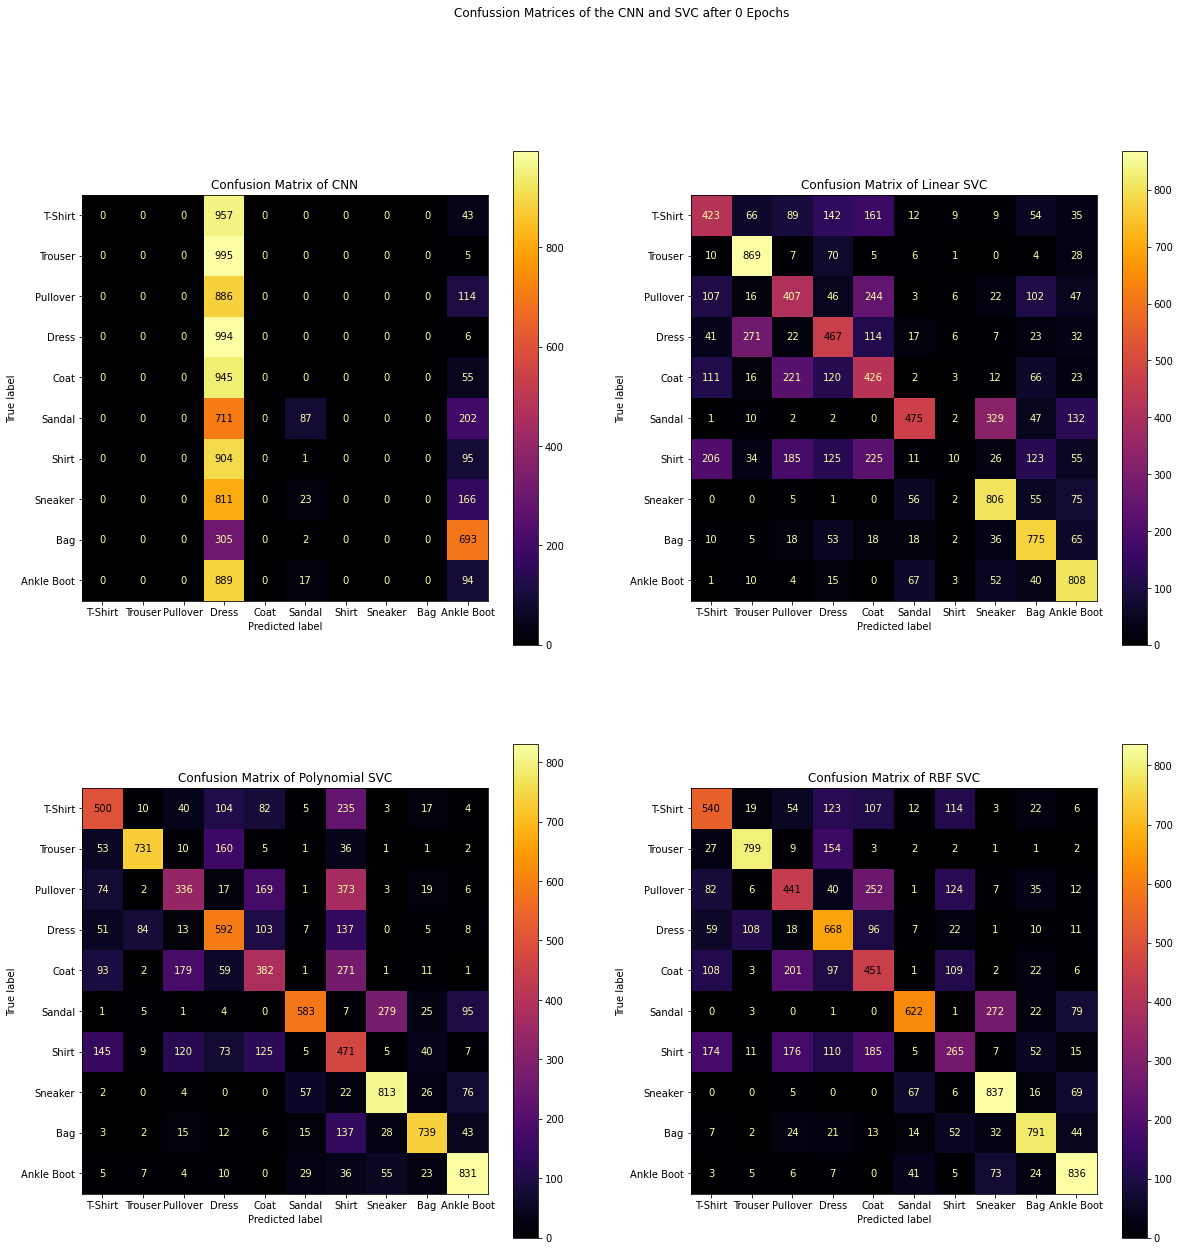

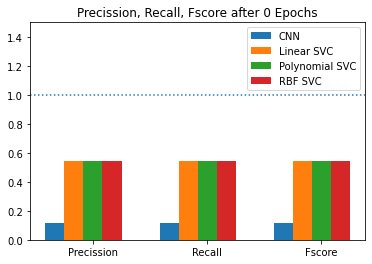

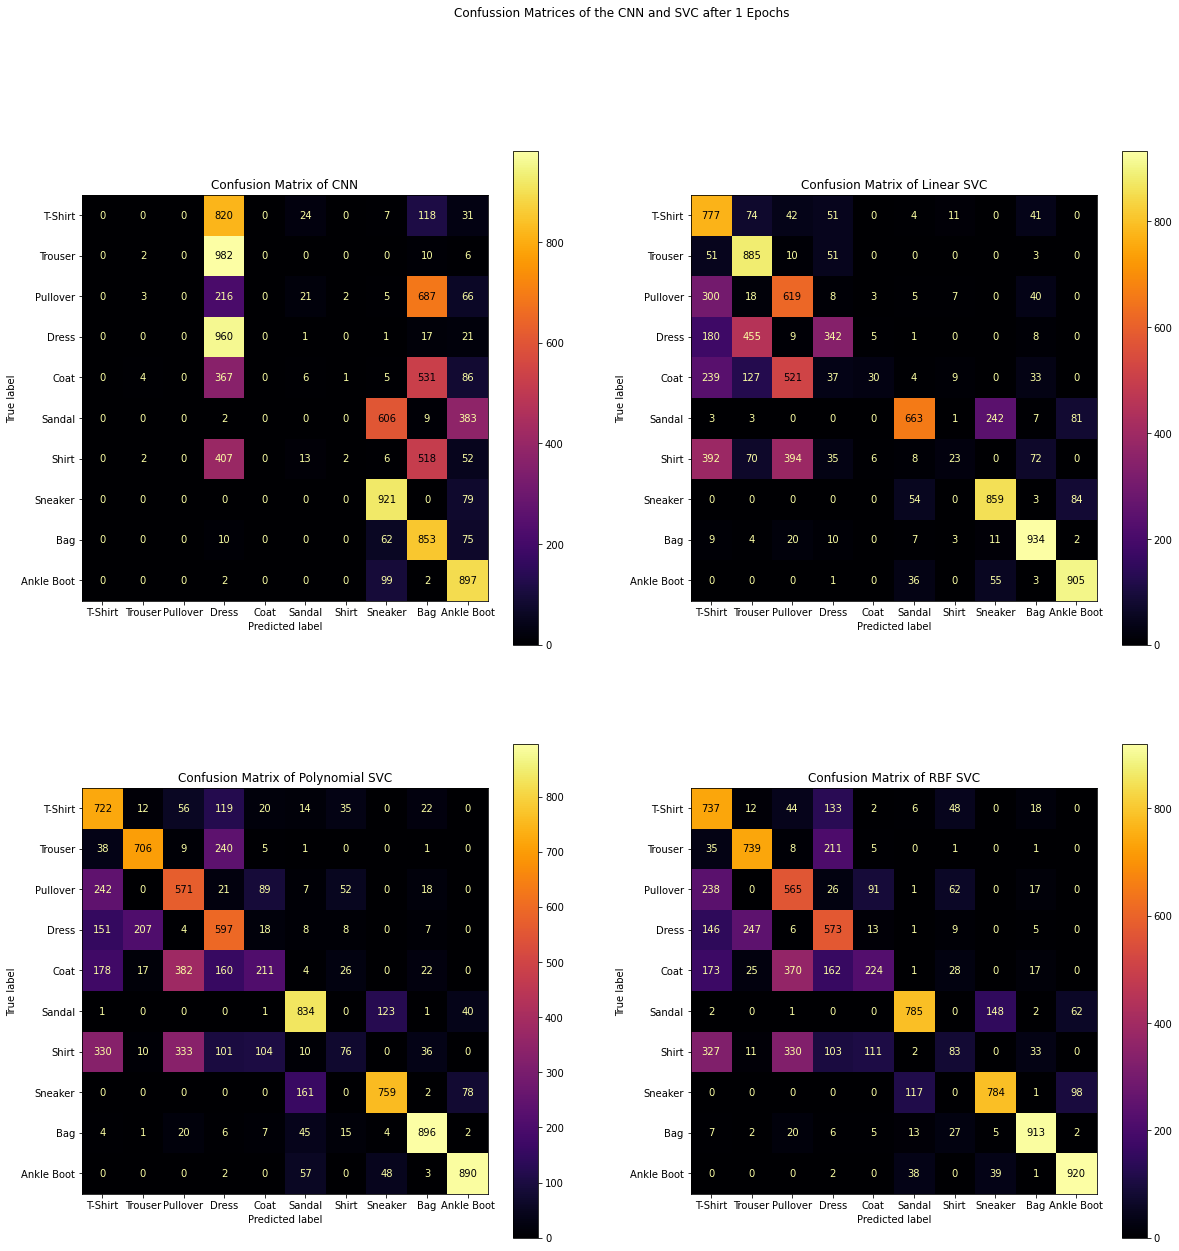

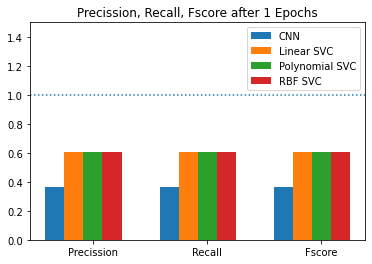

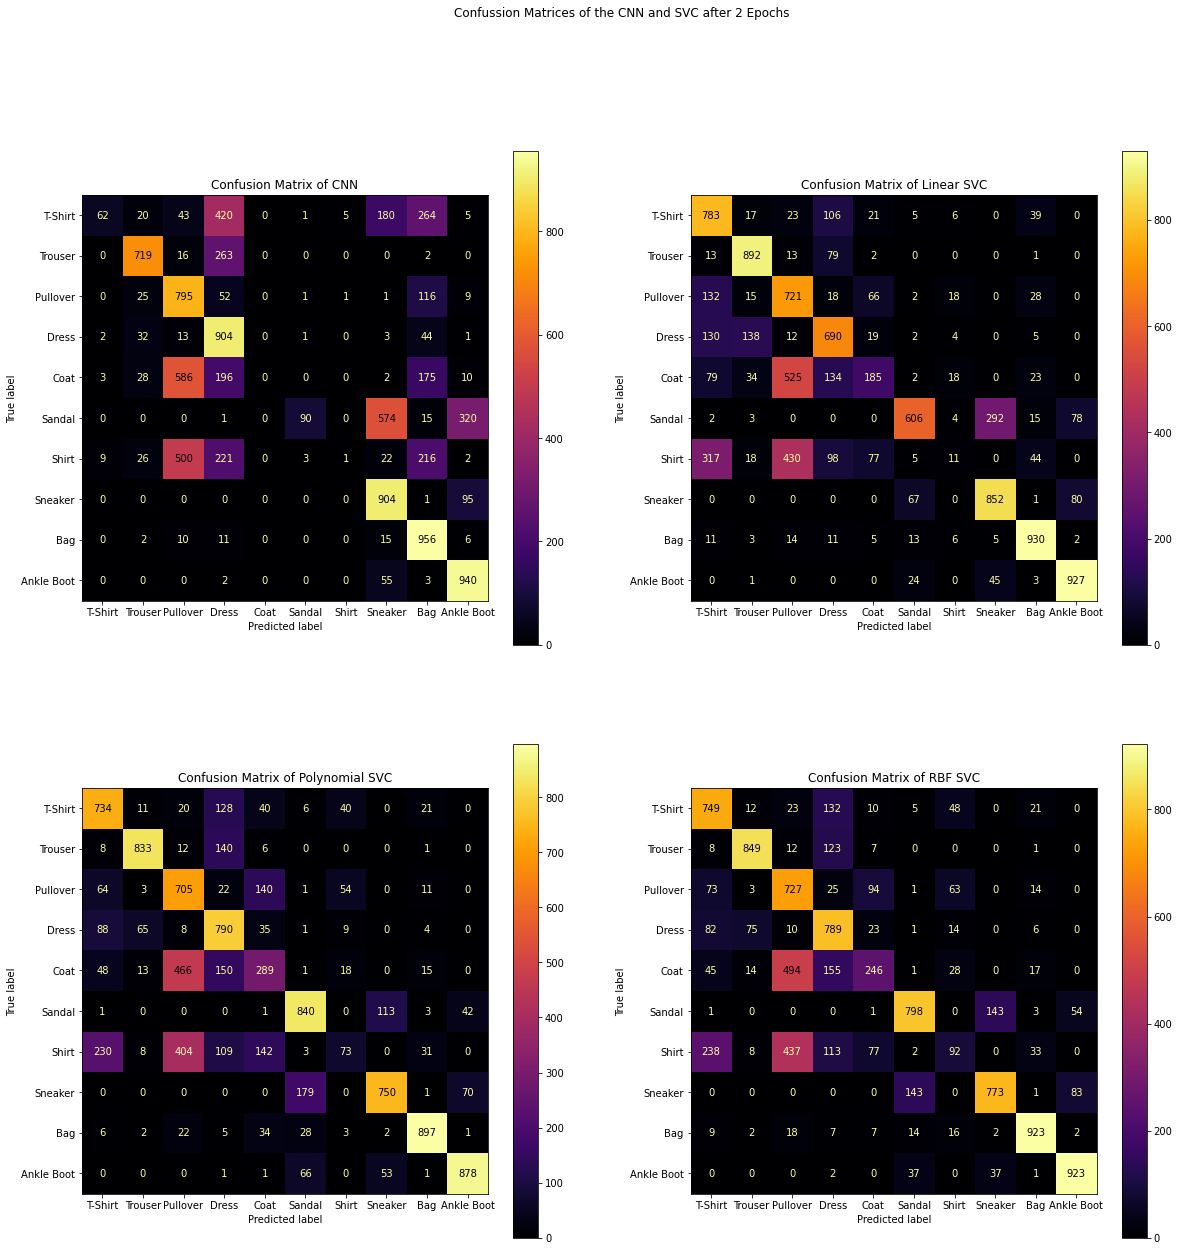

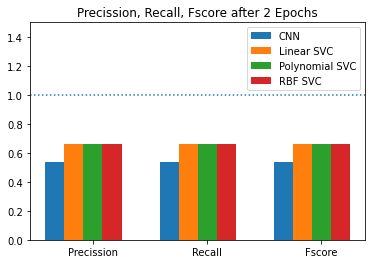

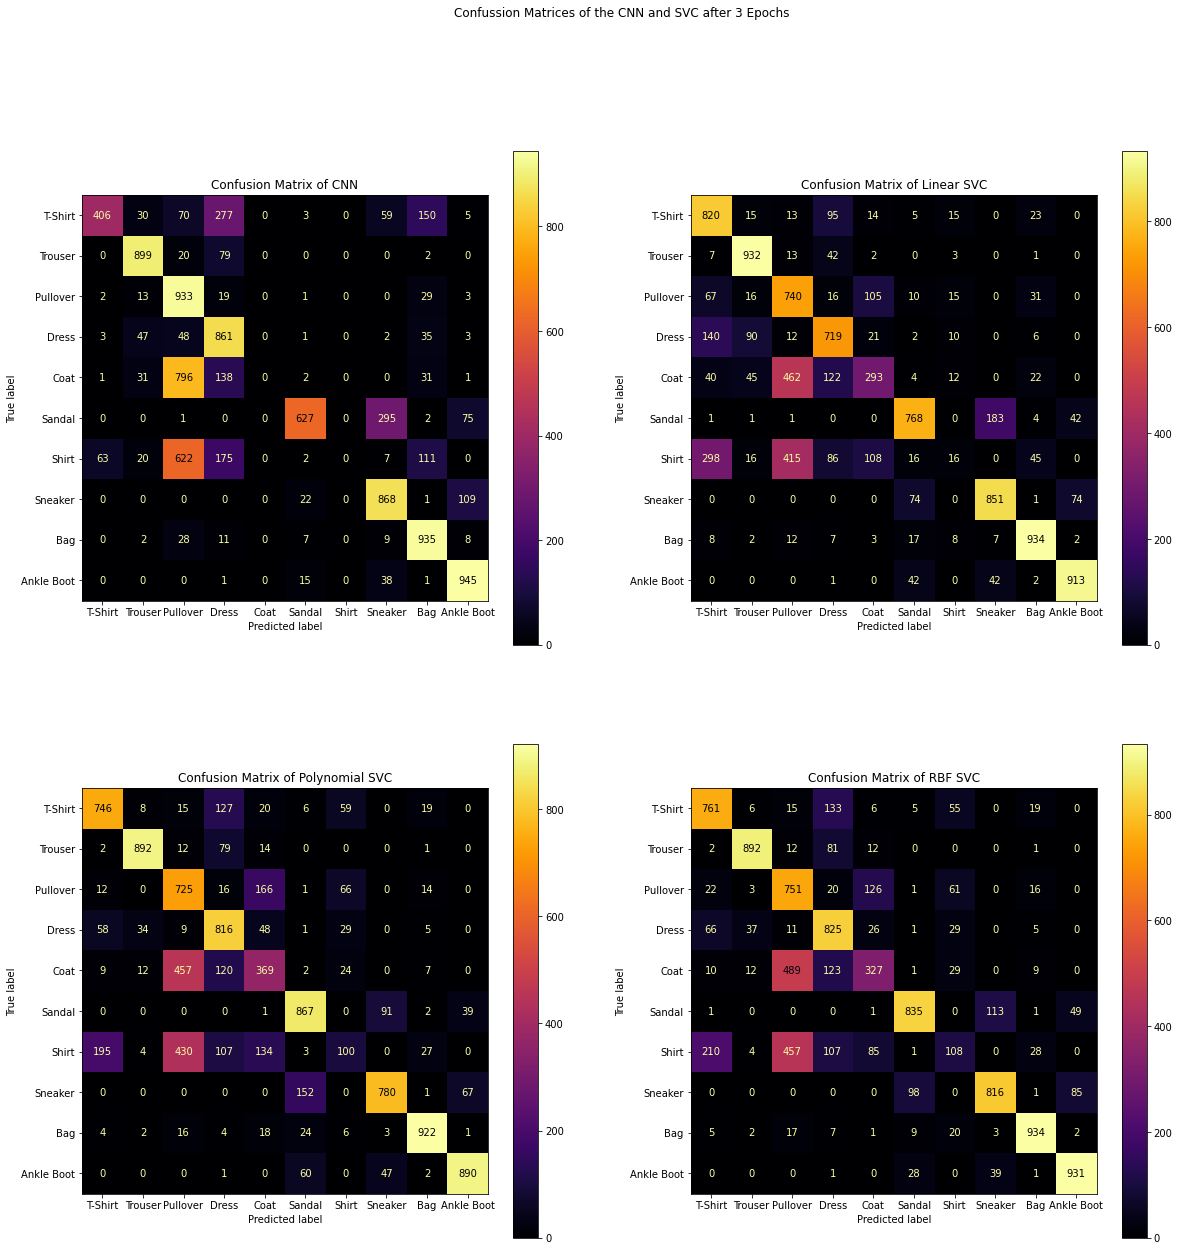

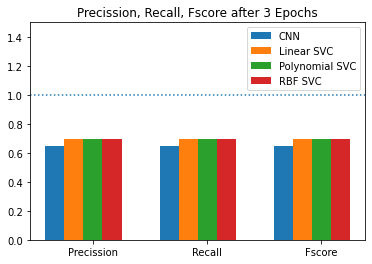

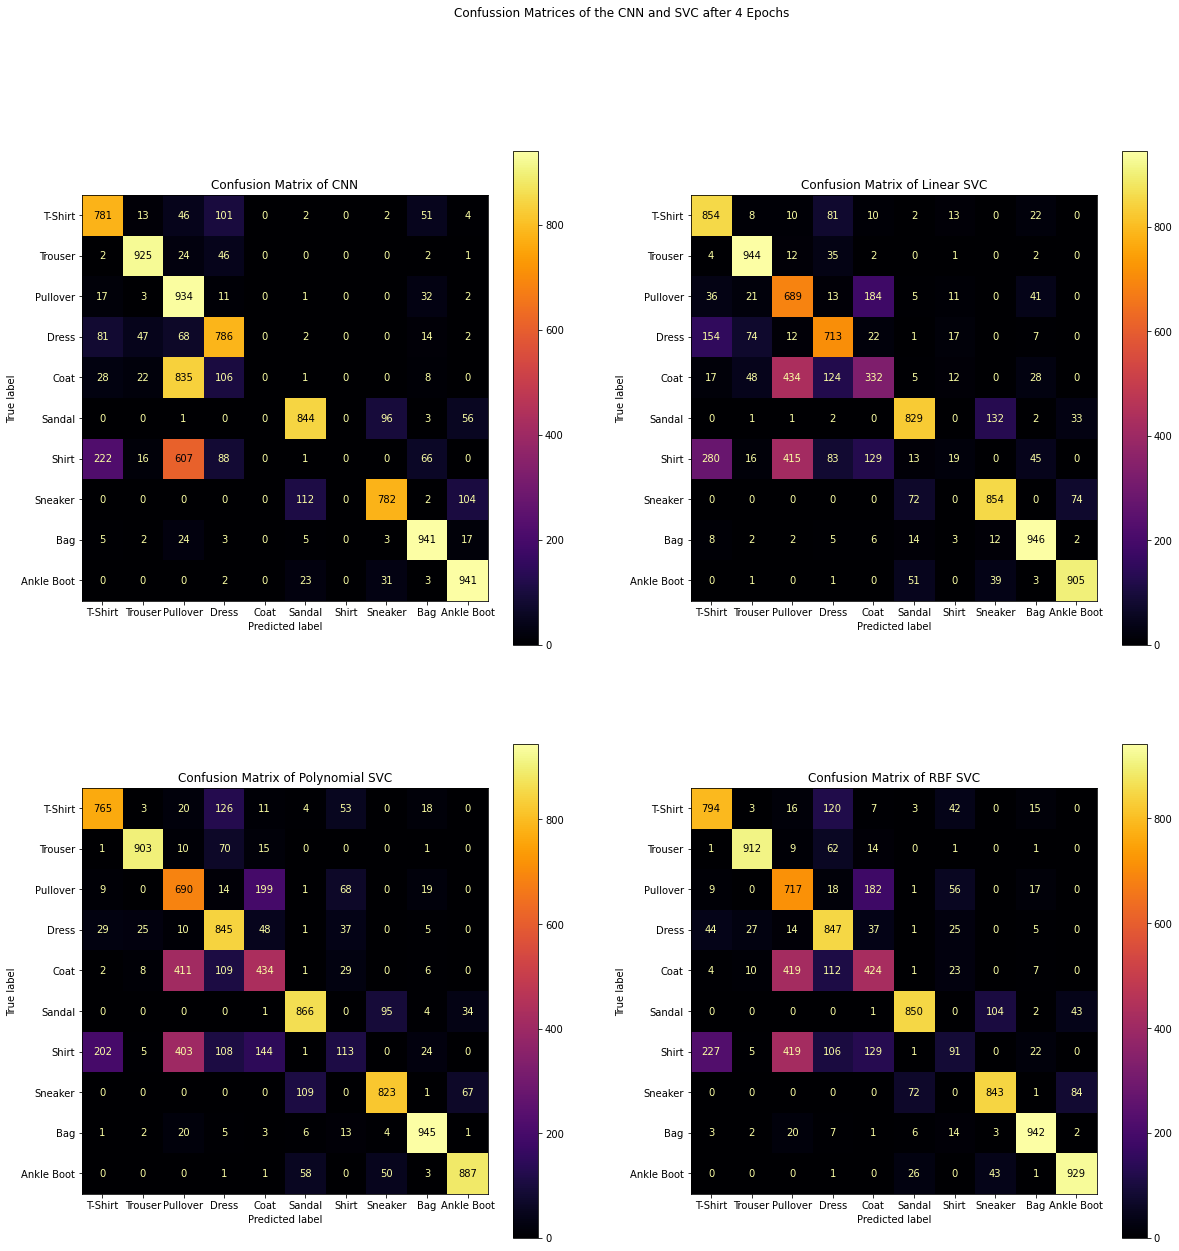

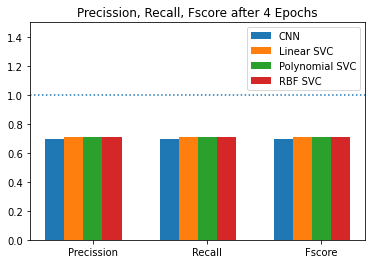

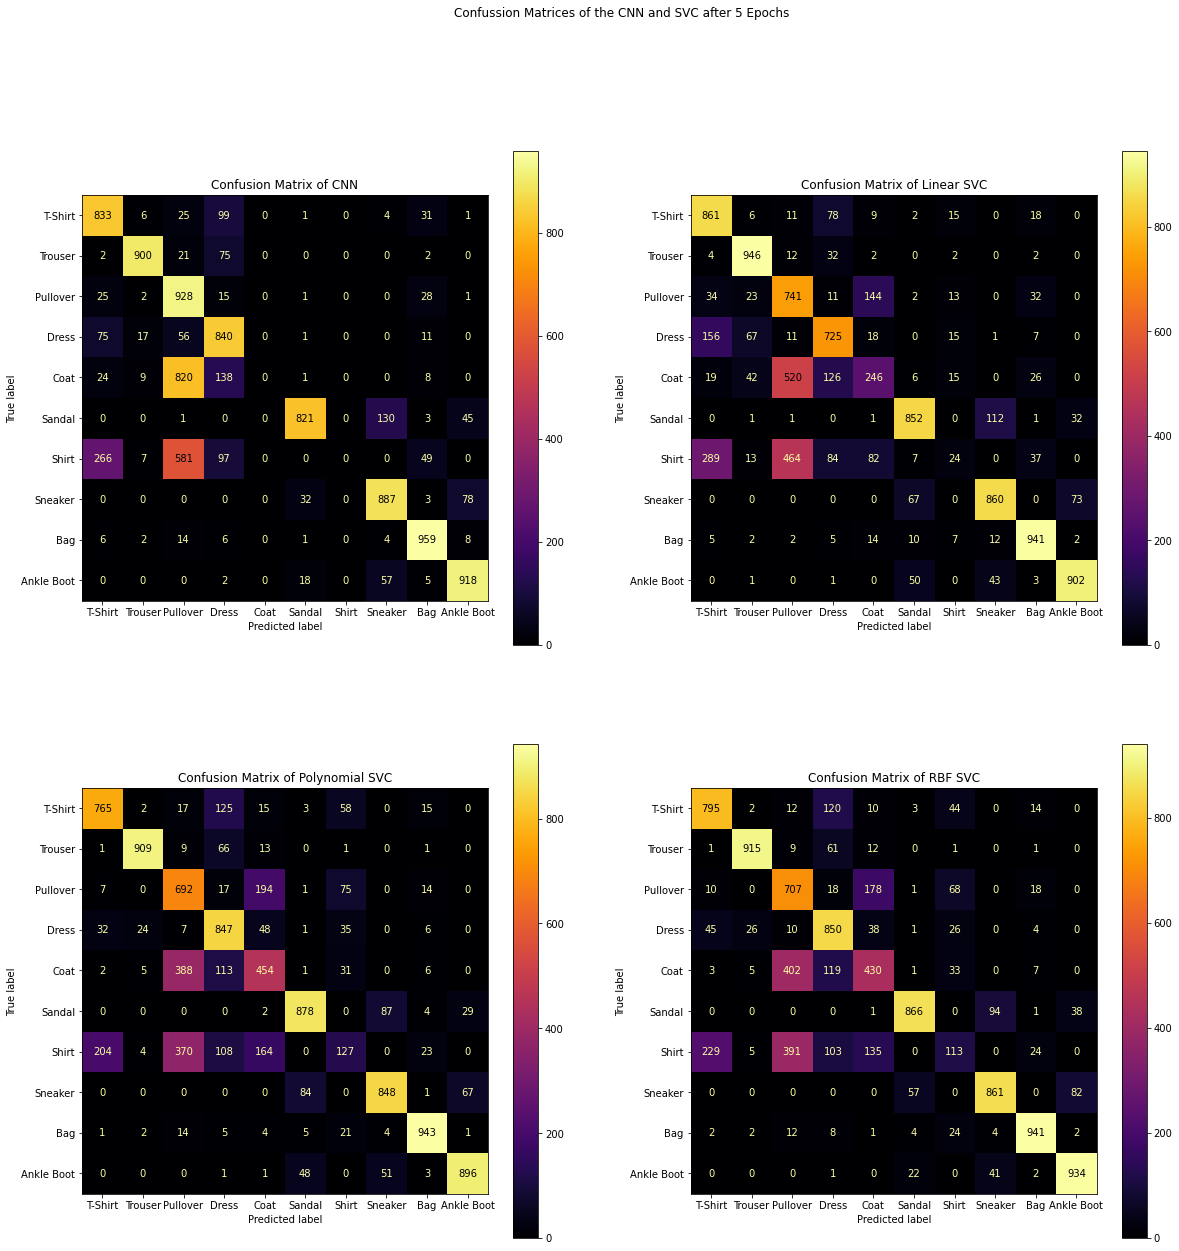

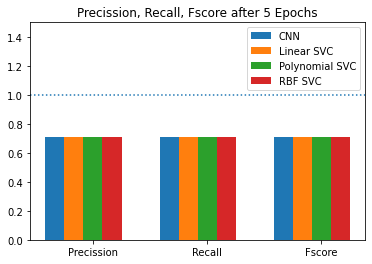

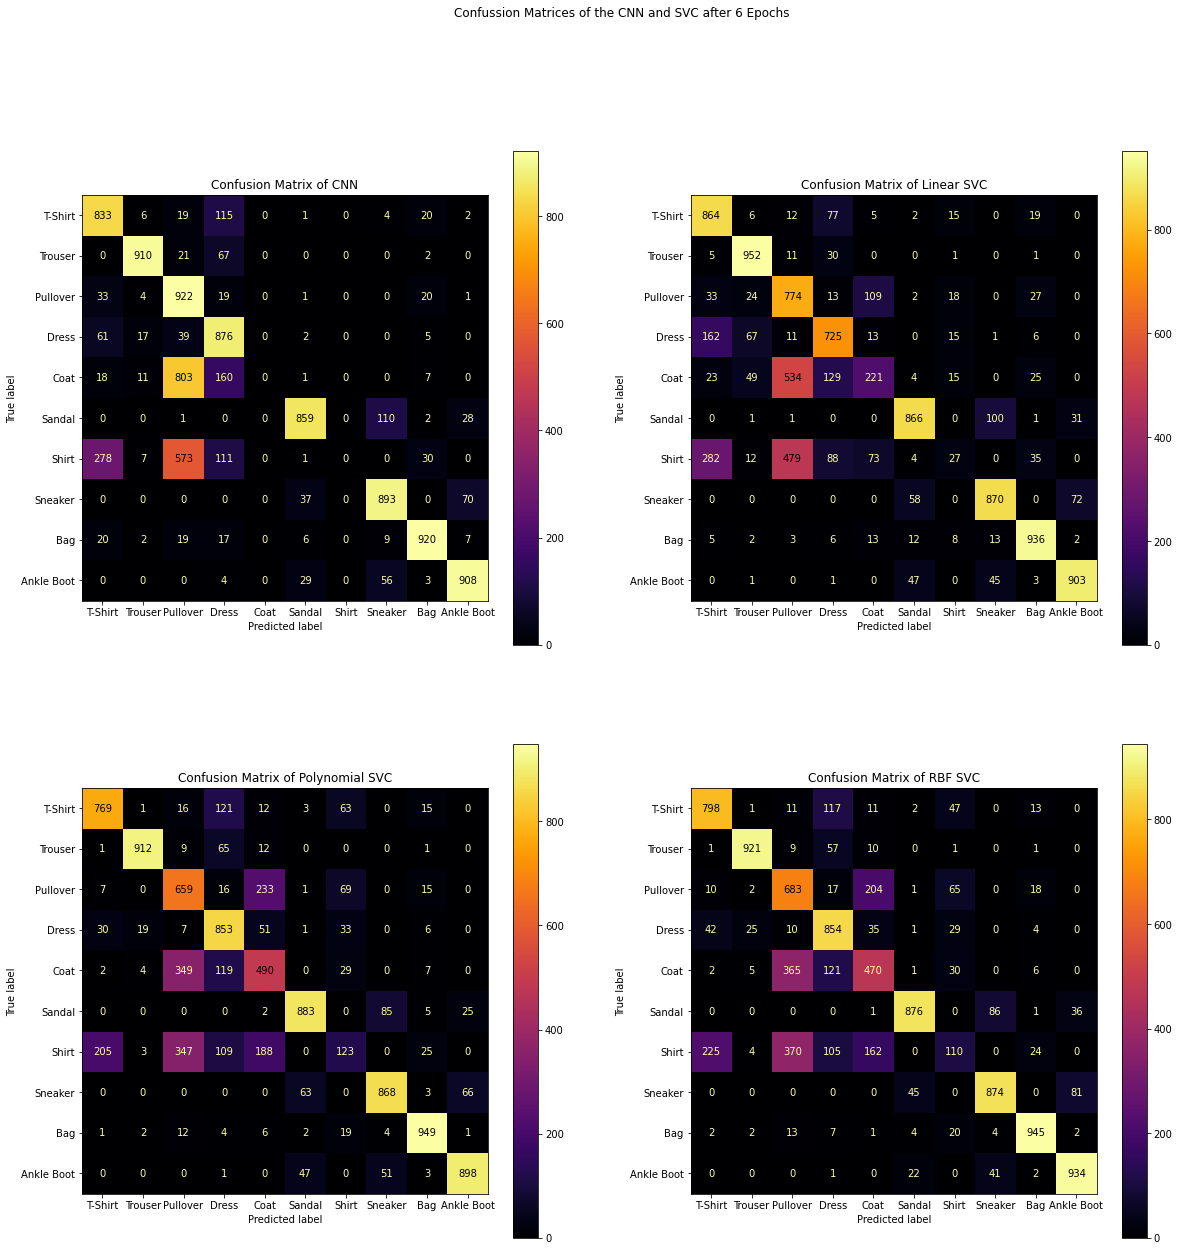

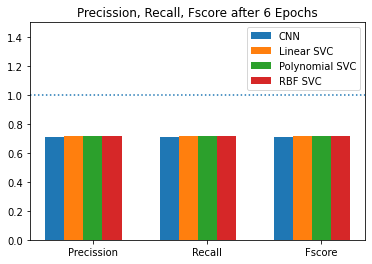

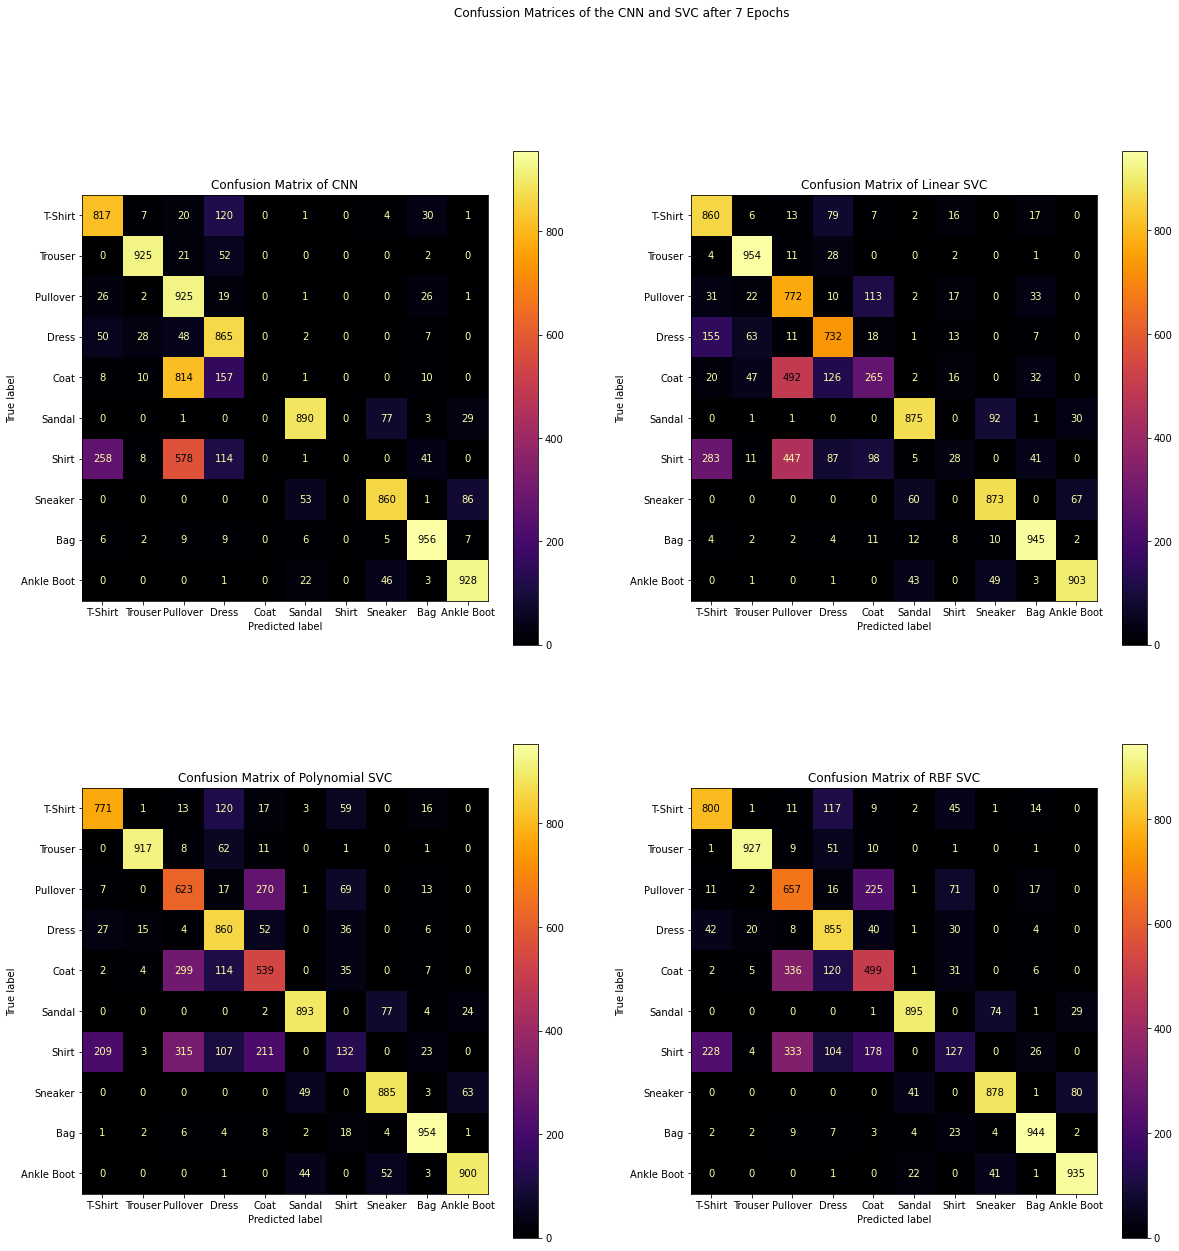

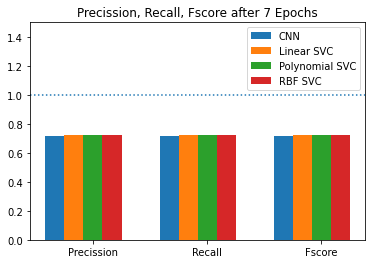

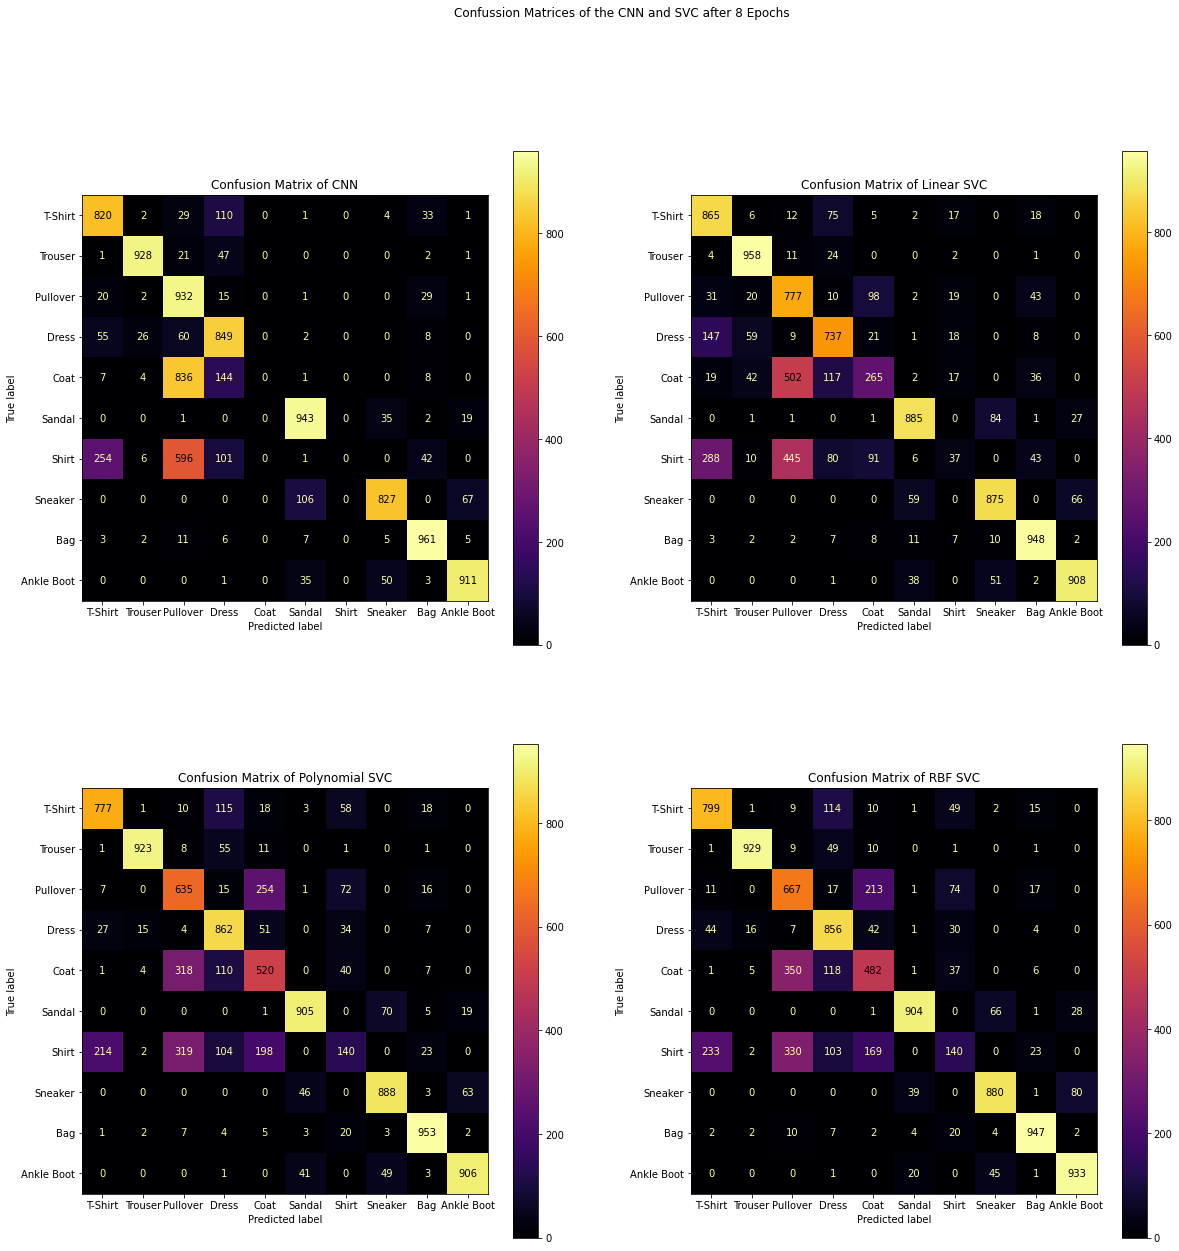

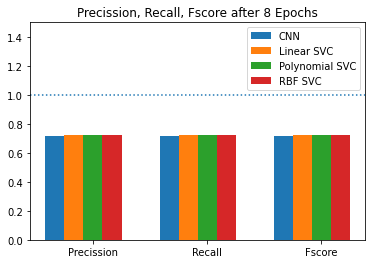

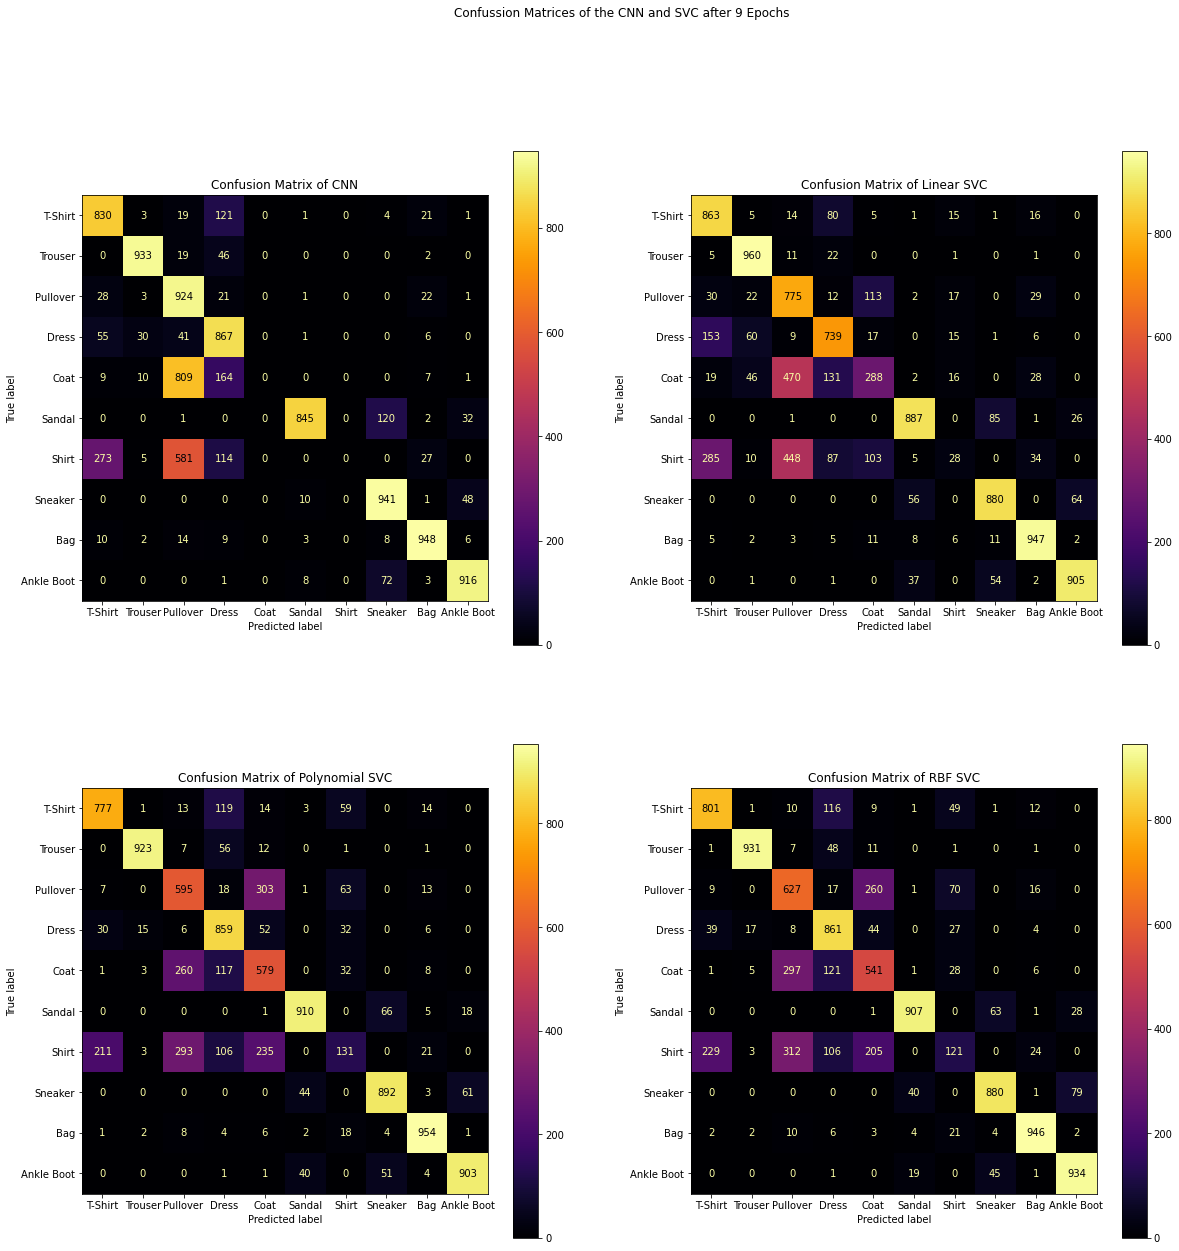

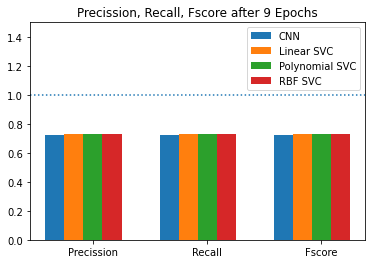

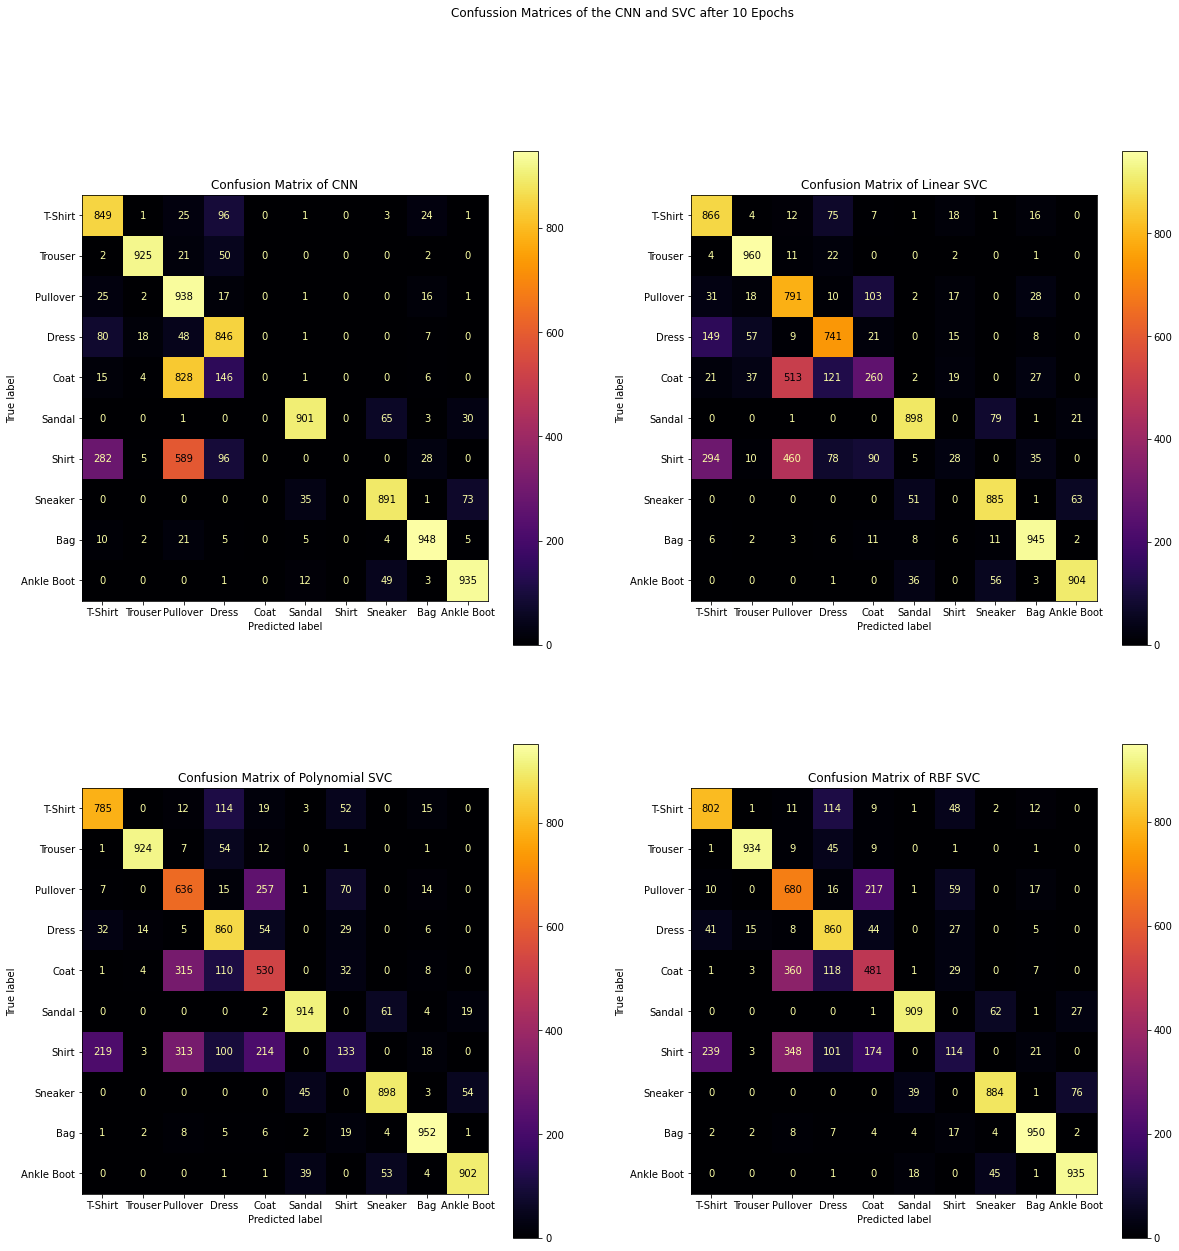

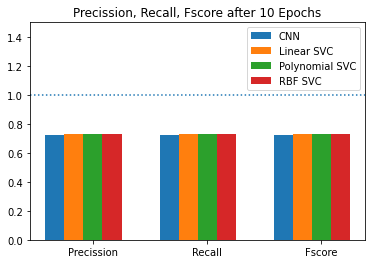

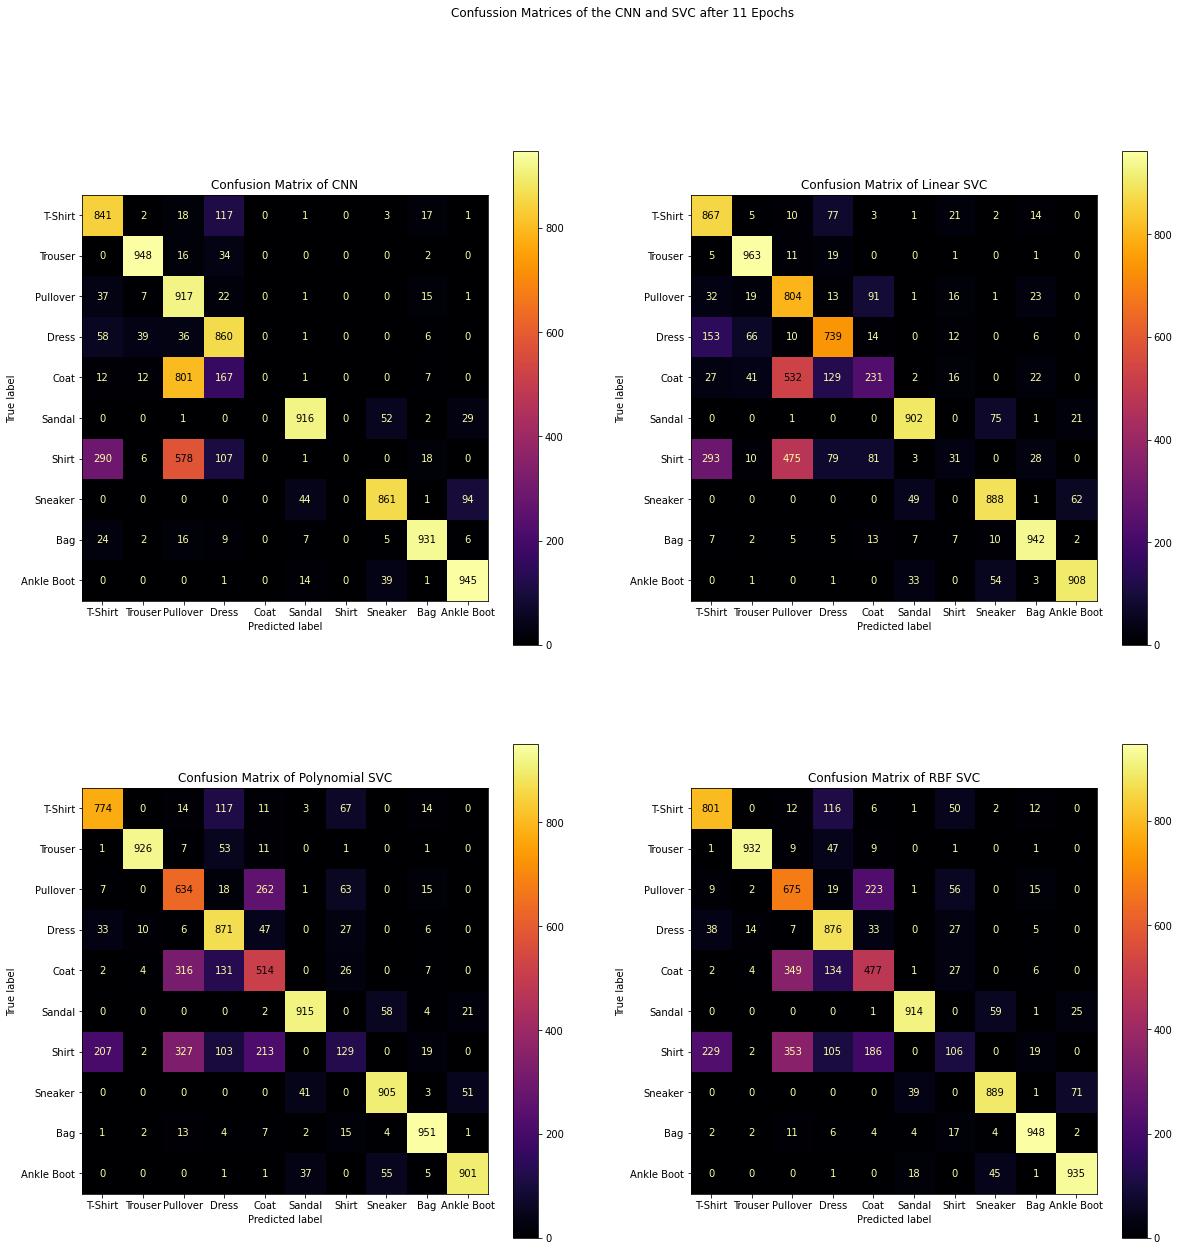

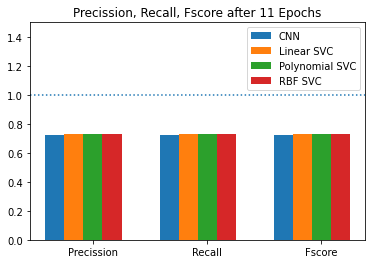

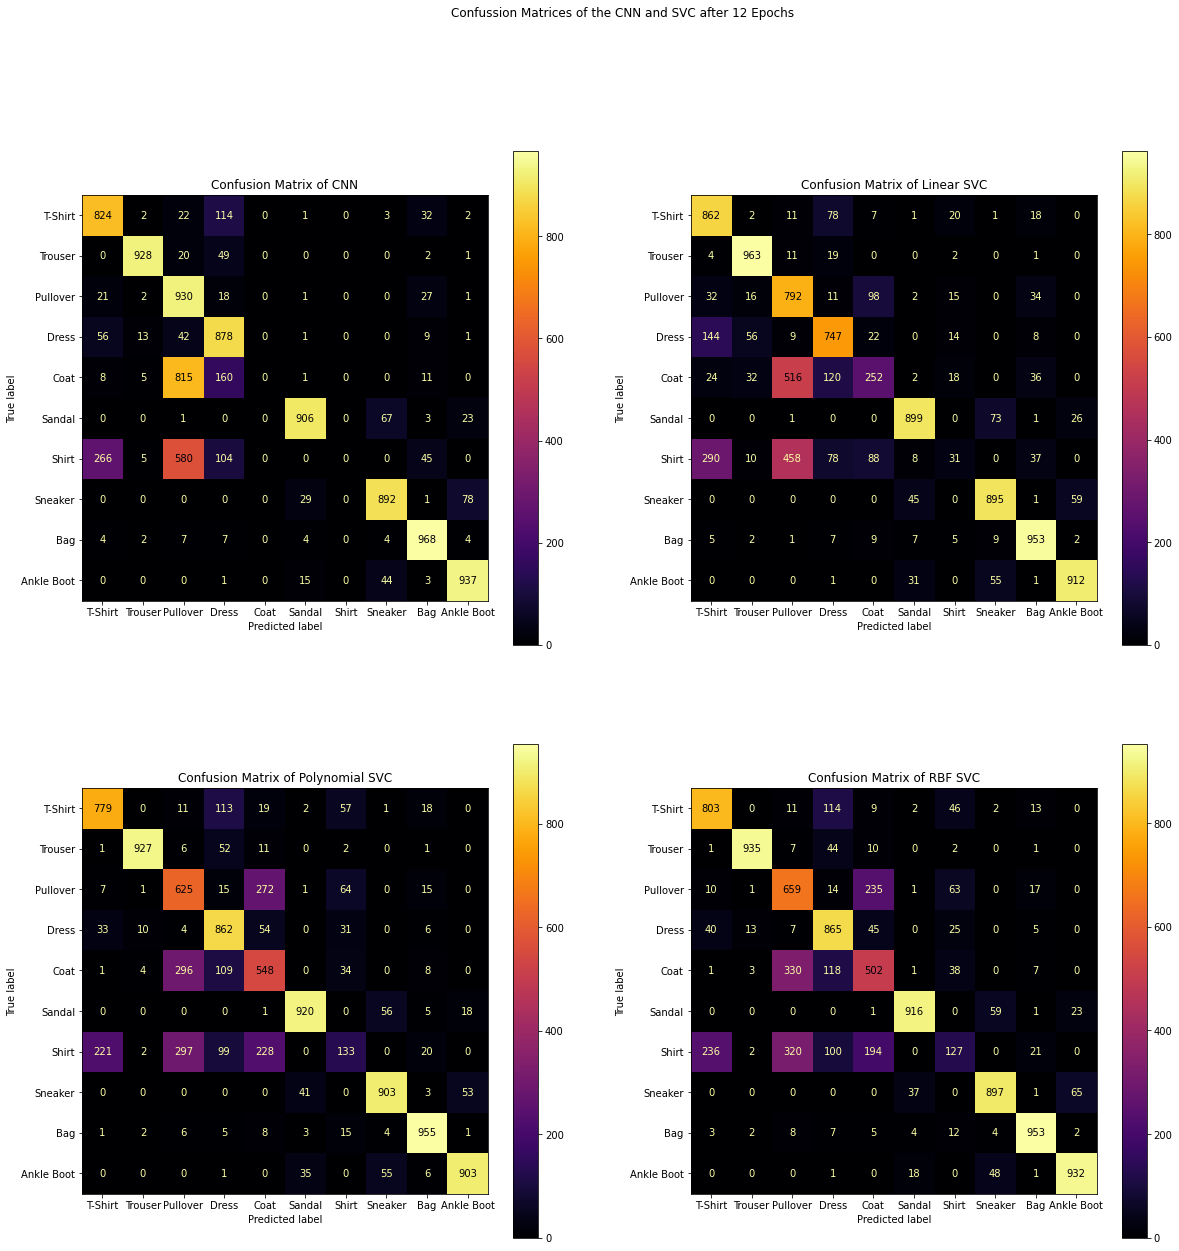

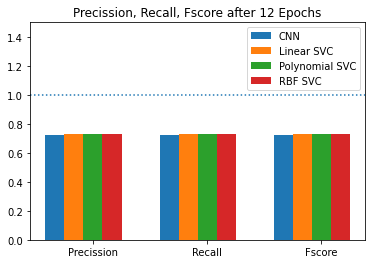

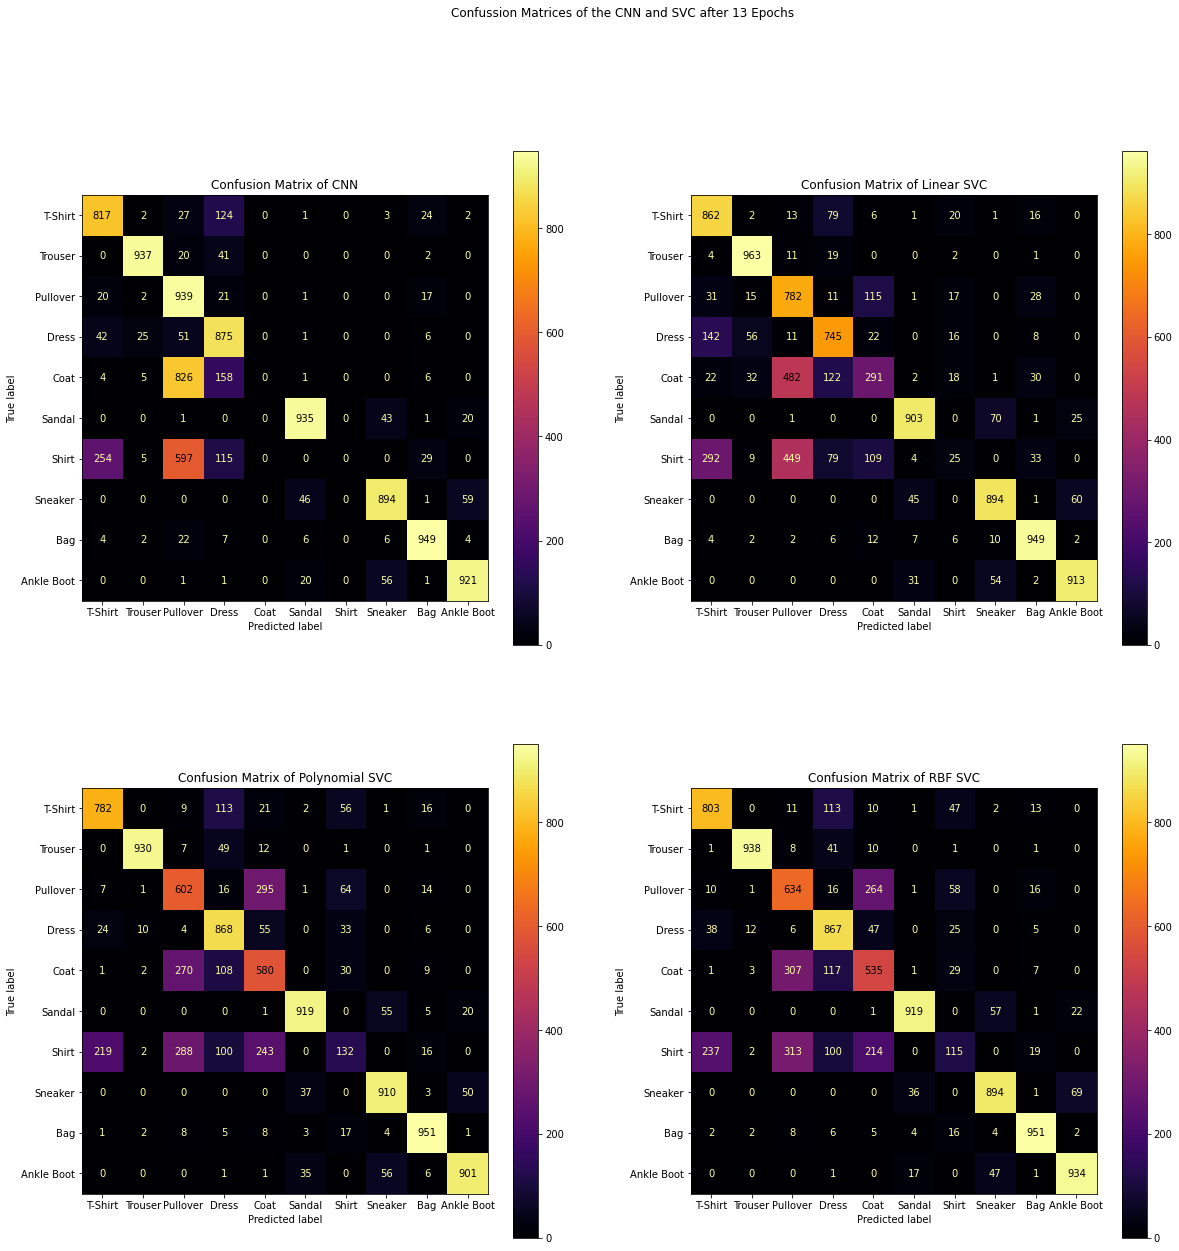

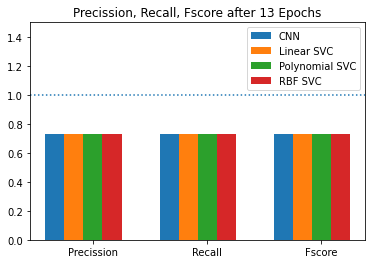

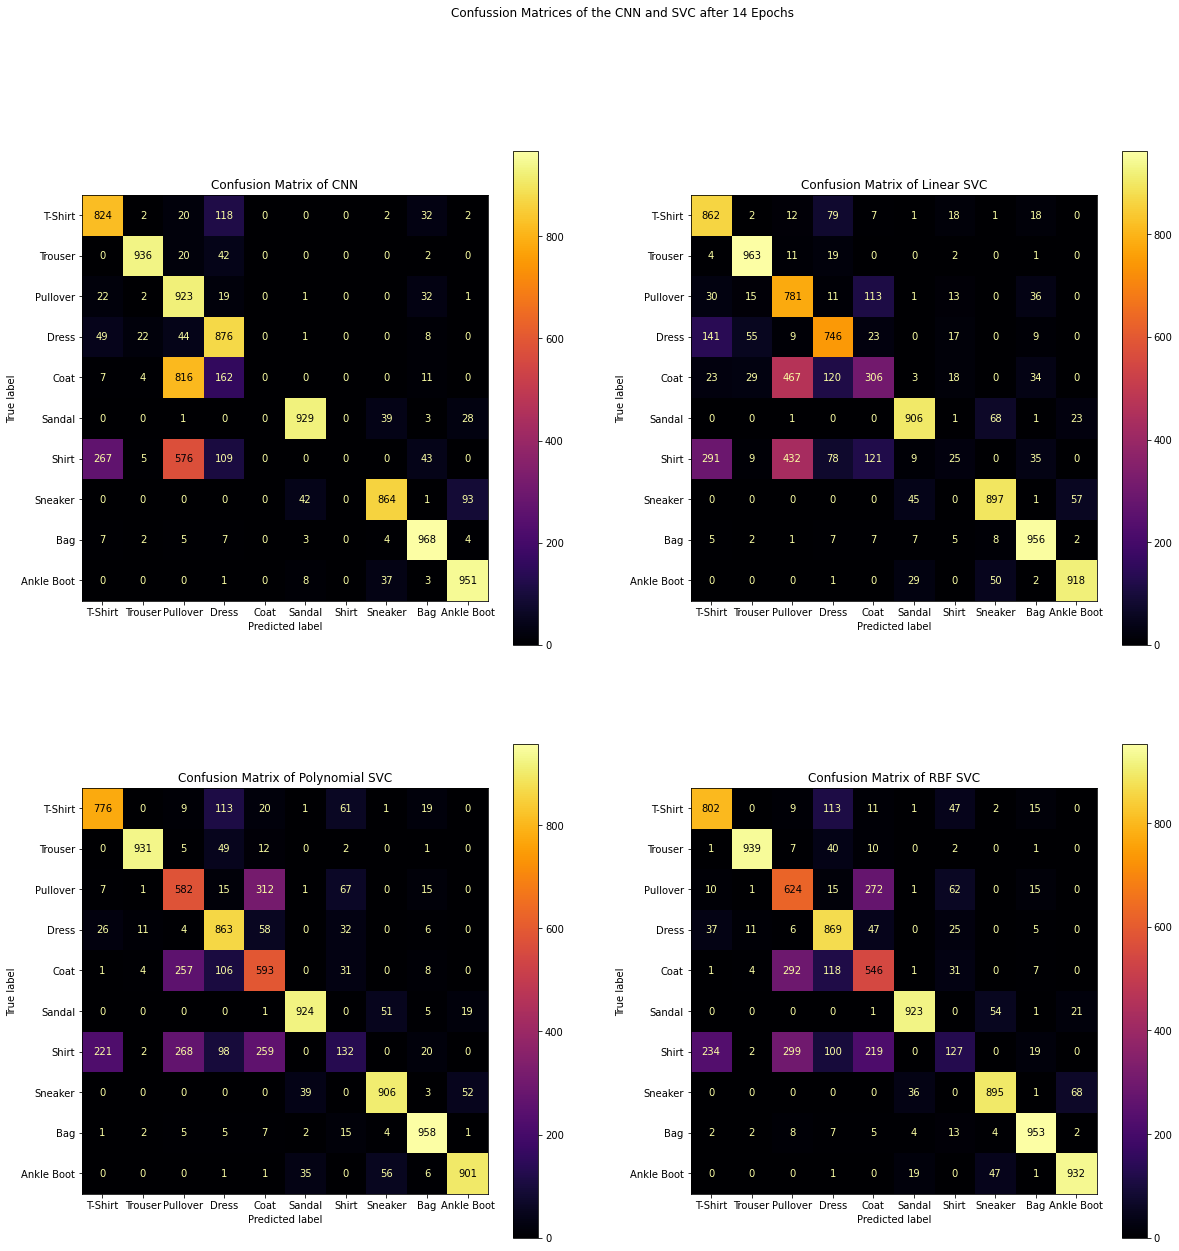

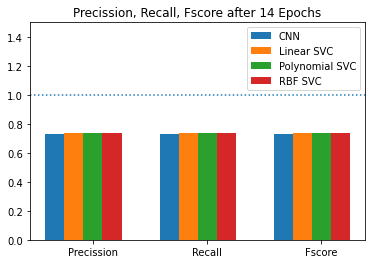

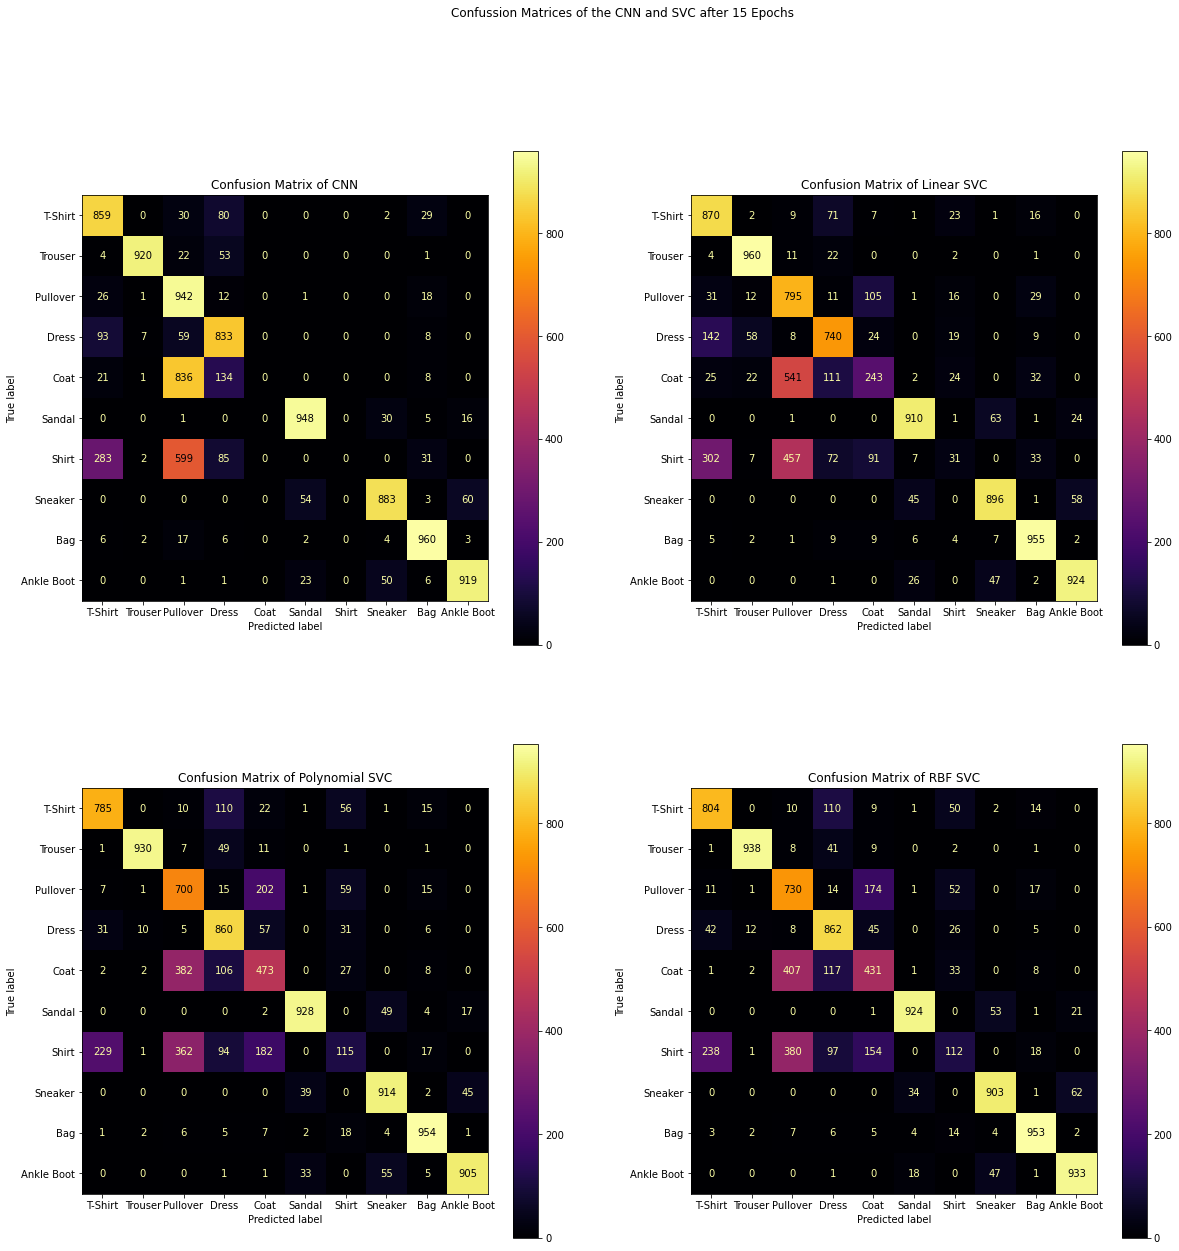

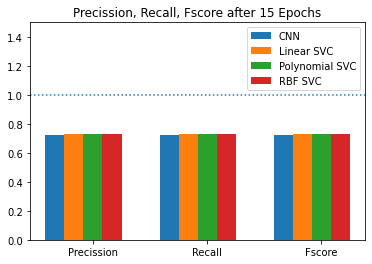

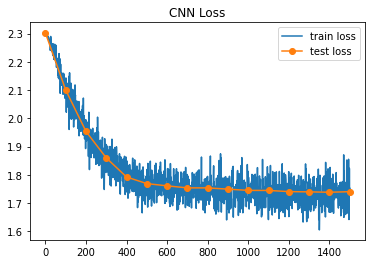

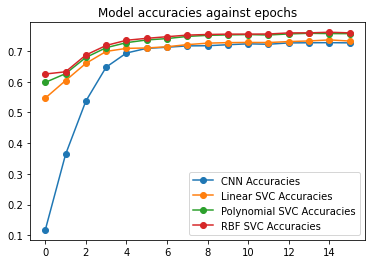

In [81]:
loss = []
t_loss = []
t_x = []
cnn_acu = []
lin_svc_acu = []
pol_svc_acu = []
rbf_svc_acu = []
all_tracks = [loss, t_loss, t_x, cnn_acu, lin_svc_acu]

enhanced_model = exp(model, 15)

In [84]:
lin_svc_acu, pol_svc_acu, rbf_svc_acu
[i[-1] for i in [cnn_acu, lin_svc_acu, pol_svc_acu, rbf_svc_acu]]

[0.7264, 0.7324, 0.7564, 0.759]

In [90]:
loss = []
t_loss = []
t_x = []
cnn_acu = []
lin_svc_acu = []
pol_svc_acu = []
rbf_svc_acu = []
all_tracks = [loss, t_loss, t_x, cnn_acu, lin_svc_acu]

model = FASSION_Classifier().to(device)

enhanced_model = exp(model, 15)

<ipython-input-89-81695dd01815>:34: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.cnn)


AttributeError: ignored